In [107]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import preliz as pz
import xarray as xr
from scipy.interpolate import PchipInterpolator
from scipy.stats import linregress


In [5]:
az.style.use("arviz-grayscale")
from cycler import cycler
default_cycler = cycler(color=["#000000", "#6a6a6a", "#bebebe", "#2a2eec"])
plt.rc('axes', prop_cycle=default_cycler)
plt.rc('figure', dpi=300)
np.random.seed(123)

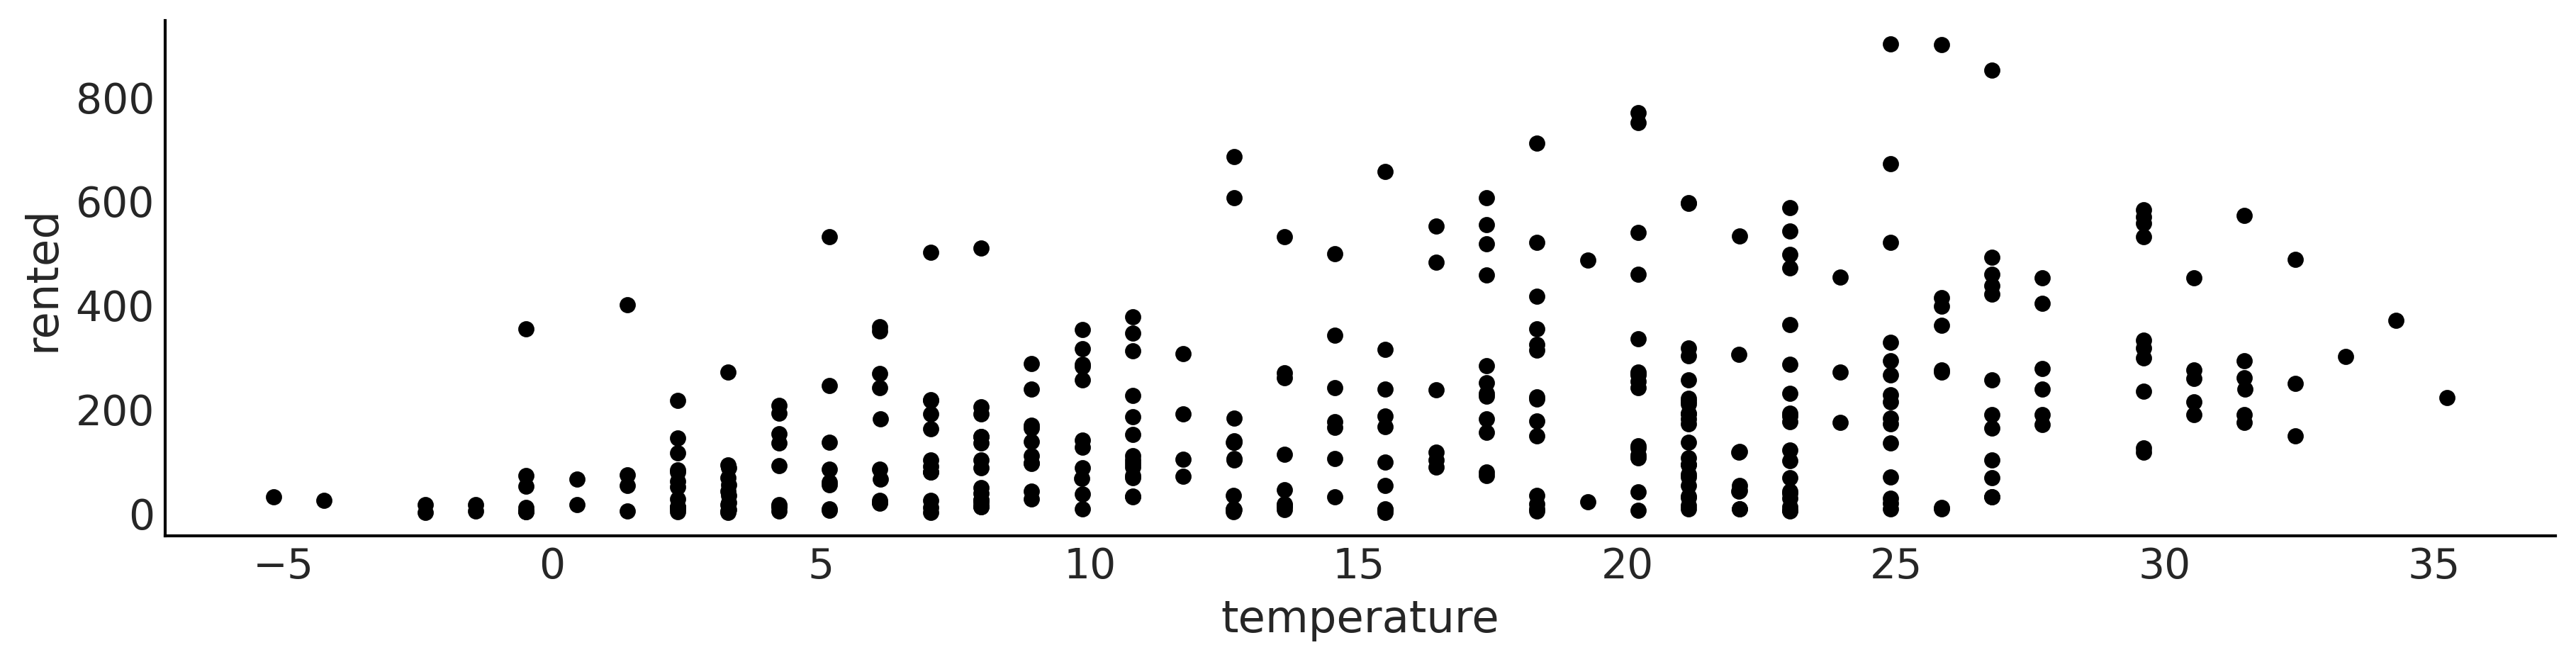

In [52]:
bikes = pd.read_csv("data/bikes.csv")
t = bikes.temperature.values
t_min=-8
t_max=39
bikes.temperature = t * (t_max-t_min) + t_min + np.random.normal(0, 0.001, len(t))
bikes.plot(x="temperature", y="rented", figsize=(12, 3), kind="scatter")
plt.savefig("../fig/bike_temperature.png")

In [7]:
with pm.Model() as model_lb:
    α = pm.Normal('α', mu=0, sigma=100)
    β = pm.Normal('β', mu=0, sigma=10)
    σ = pm.HalfCauchy('σ', 10)
    μ = pm.Deterministic('μ', α + β * bikes.temperature)
    y_pred = pm.Normal('y_pred', mu=μ, sigma=σ, observed=bikes.rented)
    idata_lb = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [8]:
# graph = pm.model_to_graphviz(model_lb)
# graph.graph_attr.update(size="4,4!")
# graph.graph_attr.update(dpi="300")
# graph.render(filename="../fig/linear_bikes_dag", format="png", cleanup=True)

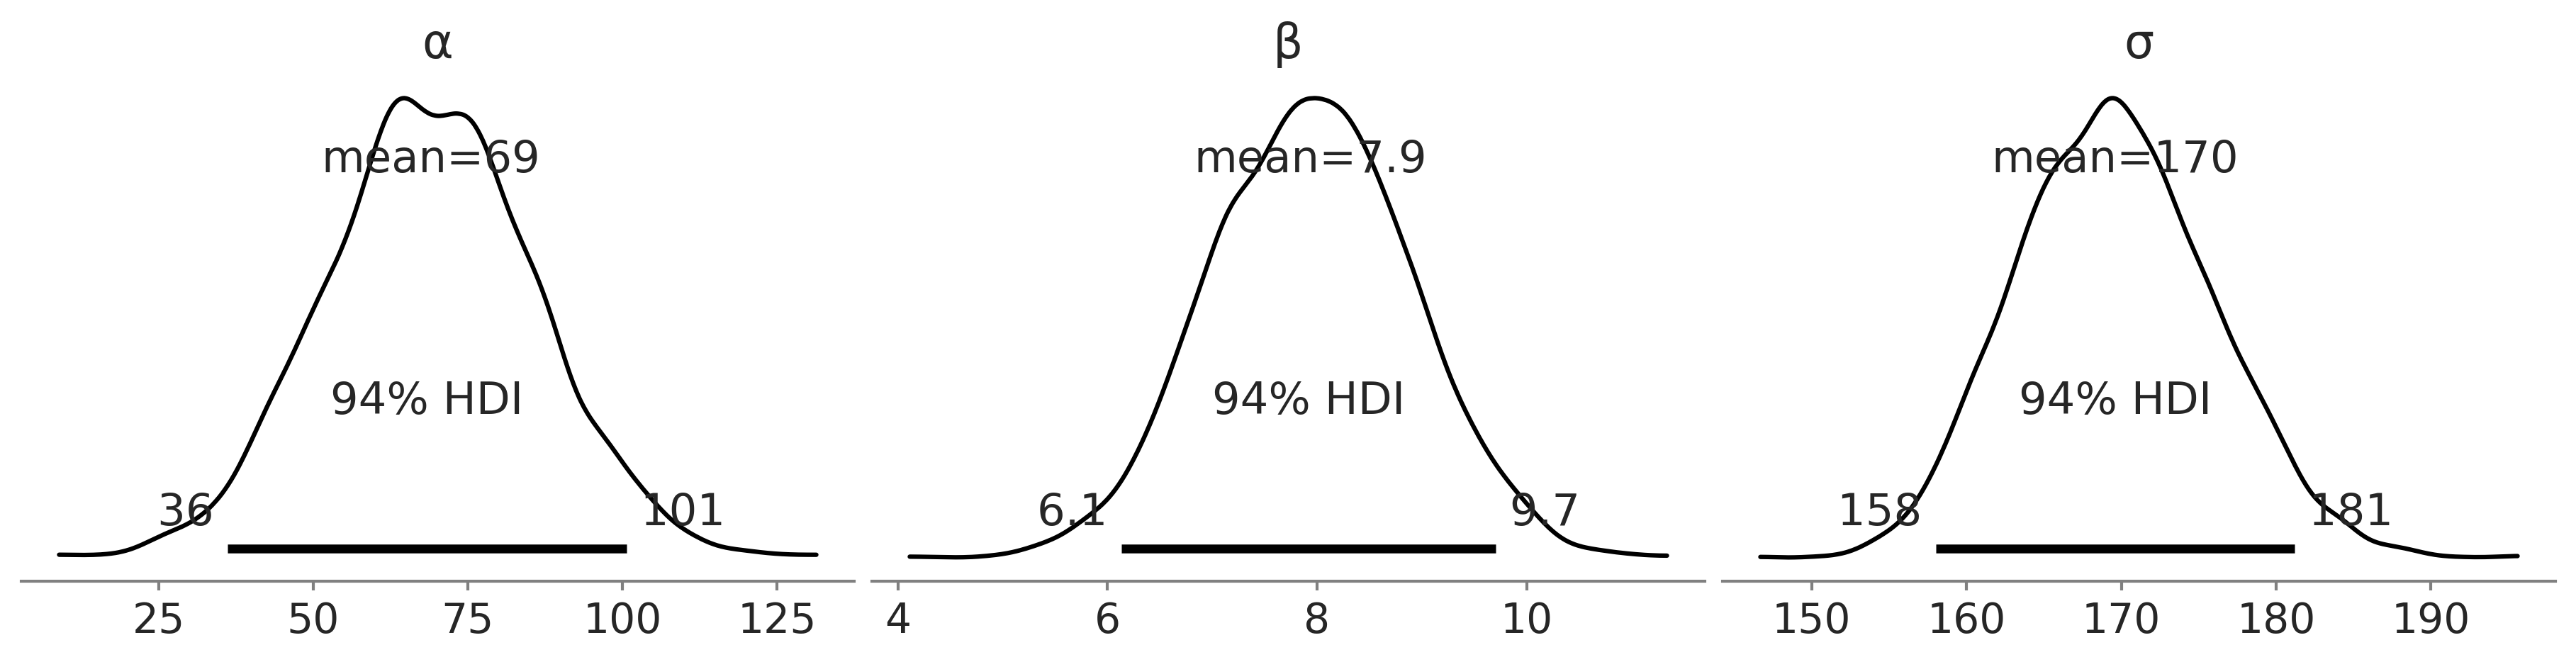

In [9]:
az.plot_posterior(idata_lb, var_names=['~μ',], figsize=(12, 3))
plt.savefig("../fig/linear_bikes_posterior.png")

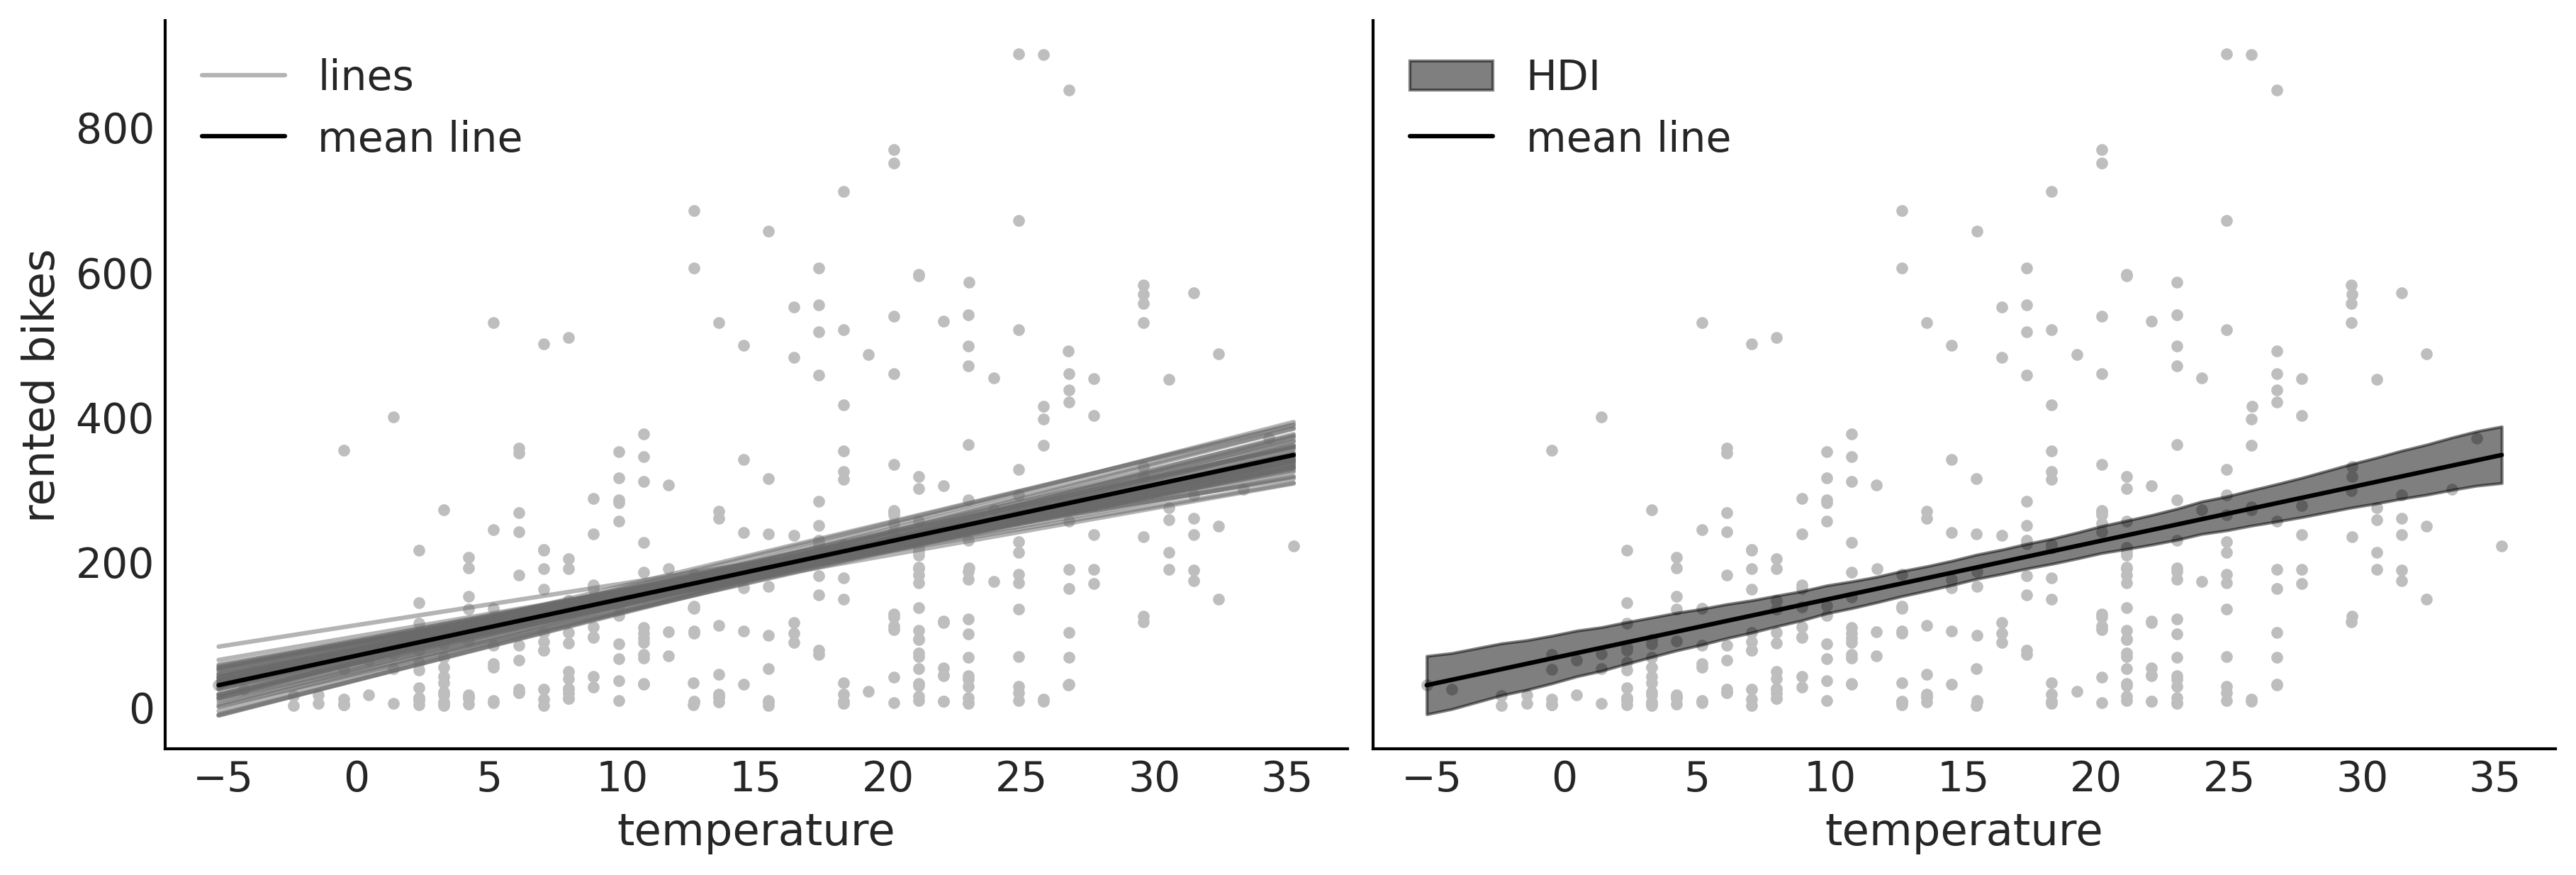

In [64]:
posterior = az.extract(idata_lb, num_samples=50)
x_plot = xr.DataArray(np.linspace(bikes.temperature.min(), bikes.temperature.max(), 50), dims="plot_id")
mean_line = posterior['α'].mean() + posterior['β'].mean() * x_plot
lines = posterior['α'] + posterior['β'] * x_plot
hdi_lines = az.hdi(idata_lb.posterior['μ'])


fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
axes[0].plot(bikes.temperature, bikes.rented, 'C2.', zorder=-3)
lines_ = axes[0].plot(x_plot, lines.T, c='C1', alpha=0.5, label='lines')
plt.setp(lines_[1:], label="_")
axes[0].plot(x_plot, mean_line, c='C0', label='mean line')
axes[0].set_xlabel('temperature')
axes[0].set_ylabel('rented bikes')
axes[0].legend()

axes[1].plot(bikes.temperature, bikes.rented, 'C2.', zorder=-3)
idx = np.argsort(bikes.temperature.values)
axes[1].fill_between(bikes.temperature[idx], hdi_lines["μ"][:,0][idx], hdi_lines["μ"][:,1][idx],
                     color="C0", label='HDI', alpha=0.5)
axes[1].plot(x_plot, mean_line, c='C0', label='mean line')
axes[1].set_xlabel('temperature')
axes[1].legend()
plt.savefig("../fig/linear_bikes_posterior_lines.png")


In [11]:
pm.sample_posterior_predictive(idata_lb, model=model_lb, extend_inferencedata=True)

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

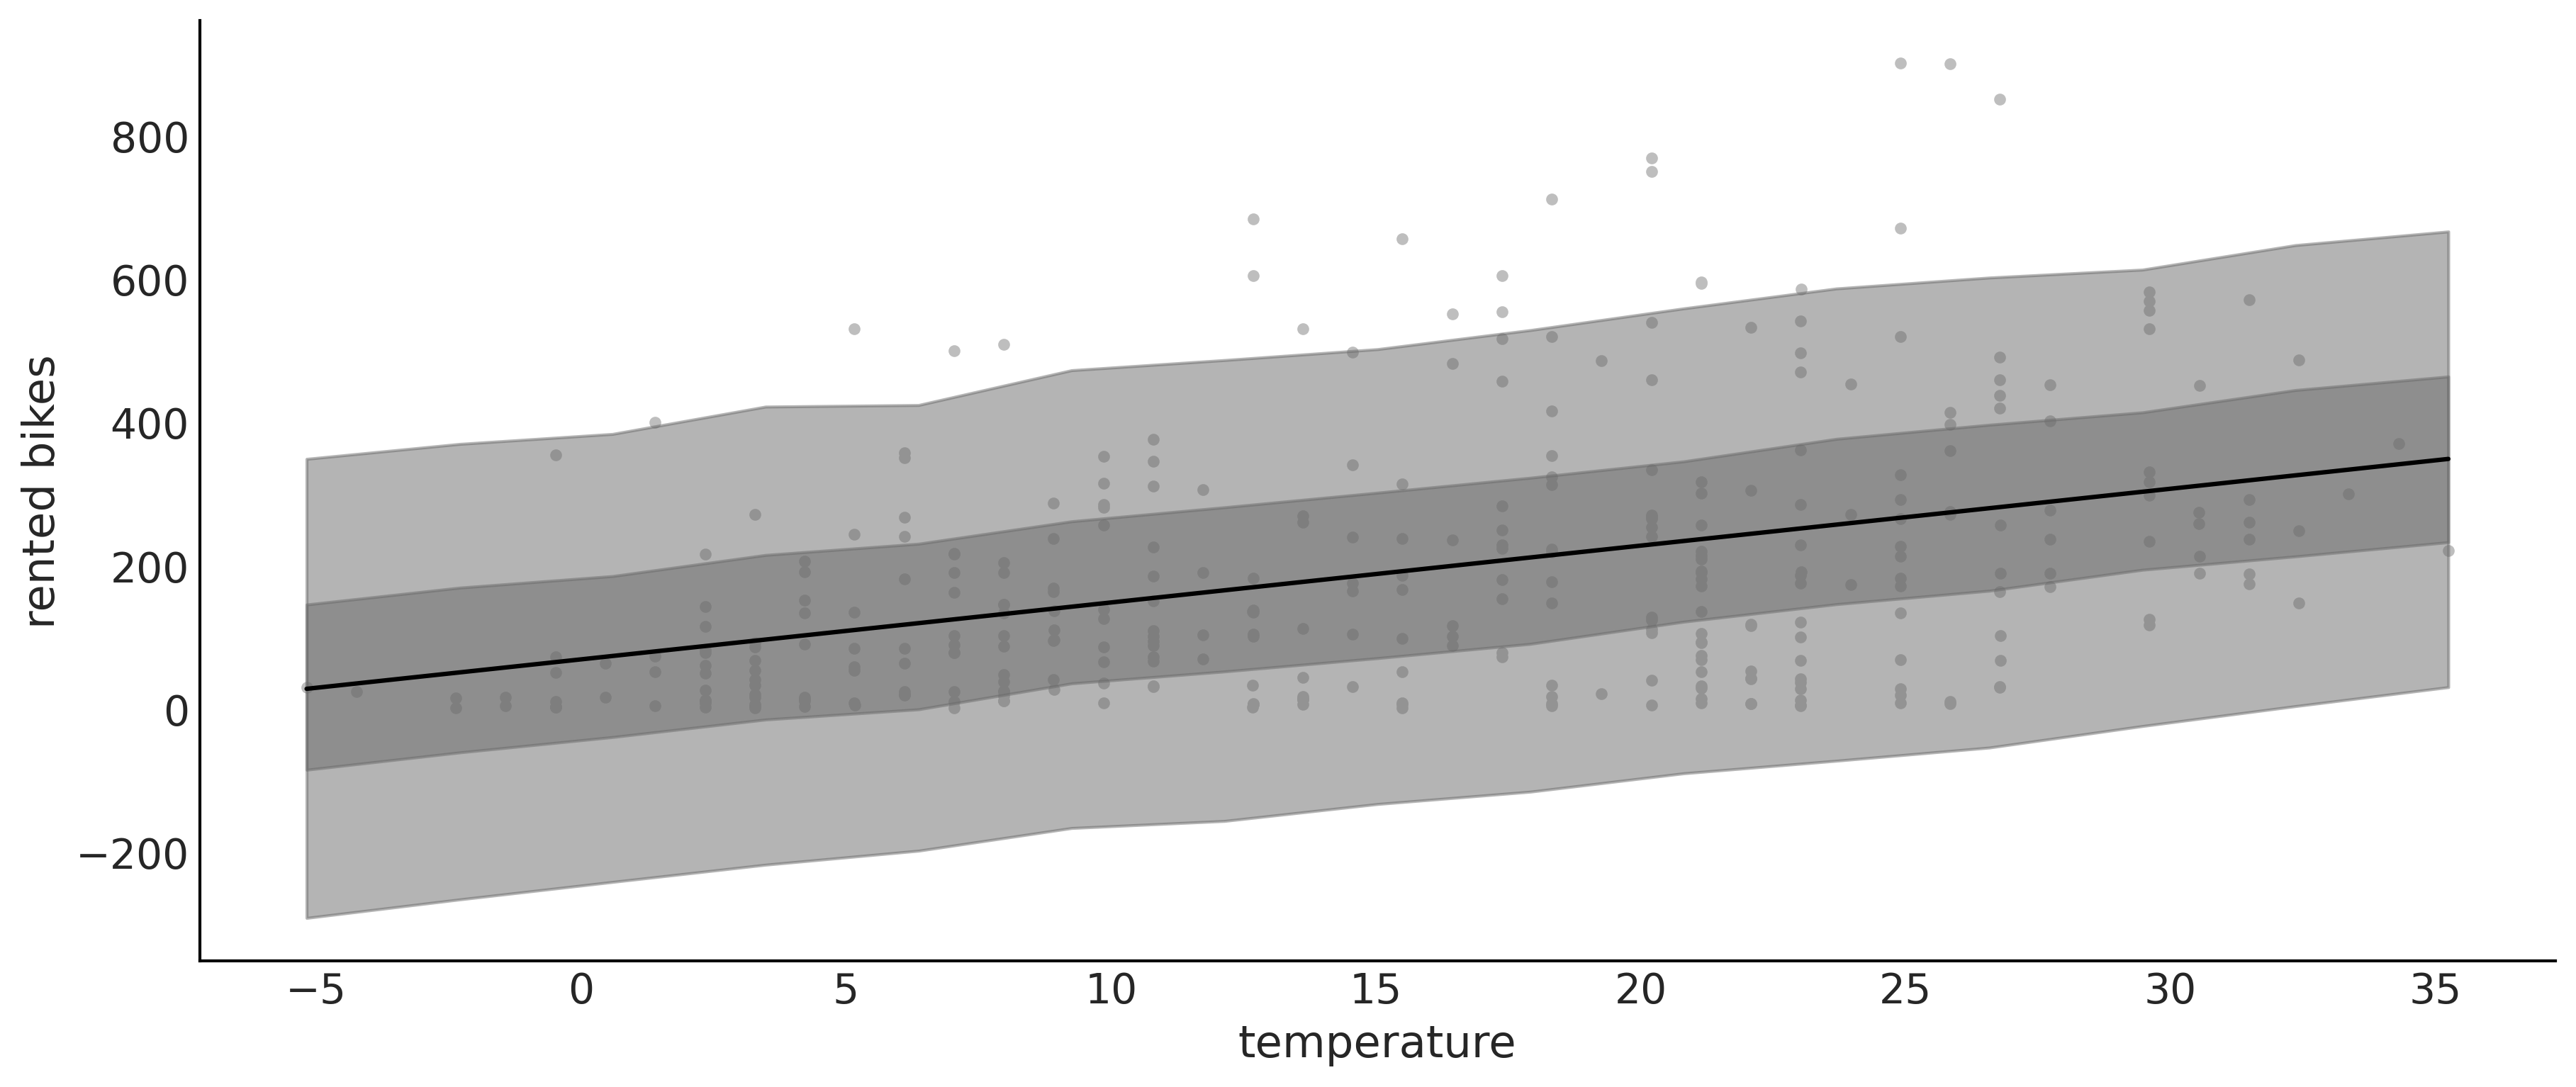

In [96]:
mean_line = idata_lb.posterior['μ'].mean(("chain", "draw"))
idx = np.argsort(bikes.temperature.values)
x = np.linspace(bikes.temperature.min(), bikes.temperature.max(), 15)
y_pred_q = idata_lb.posterior_predictive['y_pred'].quantile([0.03, 0.97, 0.25, 0.75], dim=['chain', 'draw'])
y_hat_bounds = iter([PchipInterpolator(bikes.temperature.values[idx], y_pred_q[i][idx])(x) for i in range(4)])

_, ax = plt.subplots(figsize=(12, 5))
ax.plot(bikes.temperature, bikes.rented, 'C2.', zorder=-3)
ax.plot(bikes.temperature[idx], mean_line[idx], c='C0')

for lb, ub in zip(y_hat_bounds, y_hat_bounds): 
    ax.fill_between(x,
                    lb, ub,
                    color="C1", alpha=0.5)


ax.set_xlabel('temperature')
ax.set_ylabel('rented bikes')
plt.savefig("../fig/linear_bikes_posterior_predictive.png")

In [92]:
# with pm.Model() as model_pos:
#     α = pm.Normal('α', mu=0, sigma=100)
#     β = pm.Normal('β', mu=0, sigma=10)
#     μ = pm.Deterministic('μ', pm.math.exp(α + β * bikes.temperature))
#     y_pred = pm.Poisson('y_pred', mu=μ, observed=bikes.rented)
#     idata_pos = pm.sample(idata_kwargs={"log_likelihood":True})
#     idata_pos.extend(pm.sample_posterior_predictive(idata_pos))

with pm.Model() as model_neg:
    α = pm.Normal('α', mu=0, sigma=1)
    β = pm.Normal('β', mu=0, sigma=10)
    σ = pm.HalfNormal('σ', 10)
    μ = pm.Deterministic('μ', pm.math.exp(α + β * bikes.temperature))
    y_pred = pm.NegativeBinomial('y_pred', mu=μ, alpha=σ, observed=bikes.rented)
    idata_neg = pm.sample(idata_kwargs={"log_likelihood":True})
    idata_neg.extend(pm.sample_posterior_predictive(idata_neg))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


array([[<AxesSubplot:title={'center':'α'}>,
        <AxesSubplot:title={'center':'α'}>],
       [<AxesSubplot:title={'center':'β'}>,
        <AxesSubplot:title={'center':'β'}>],
       [<AxesSubplot:title={'center':'σ'}>,
        <AxesSubplot:title={'center':'σ'}>]], dtype=object)

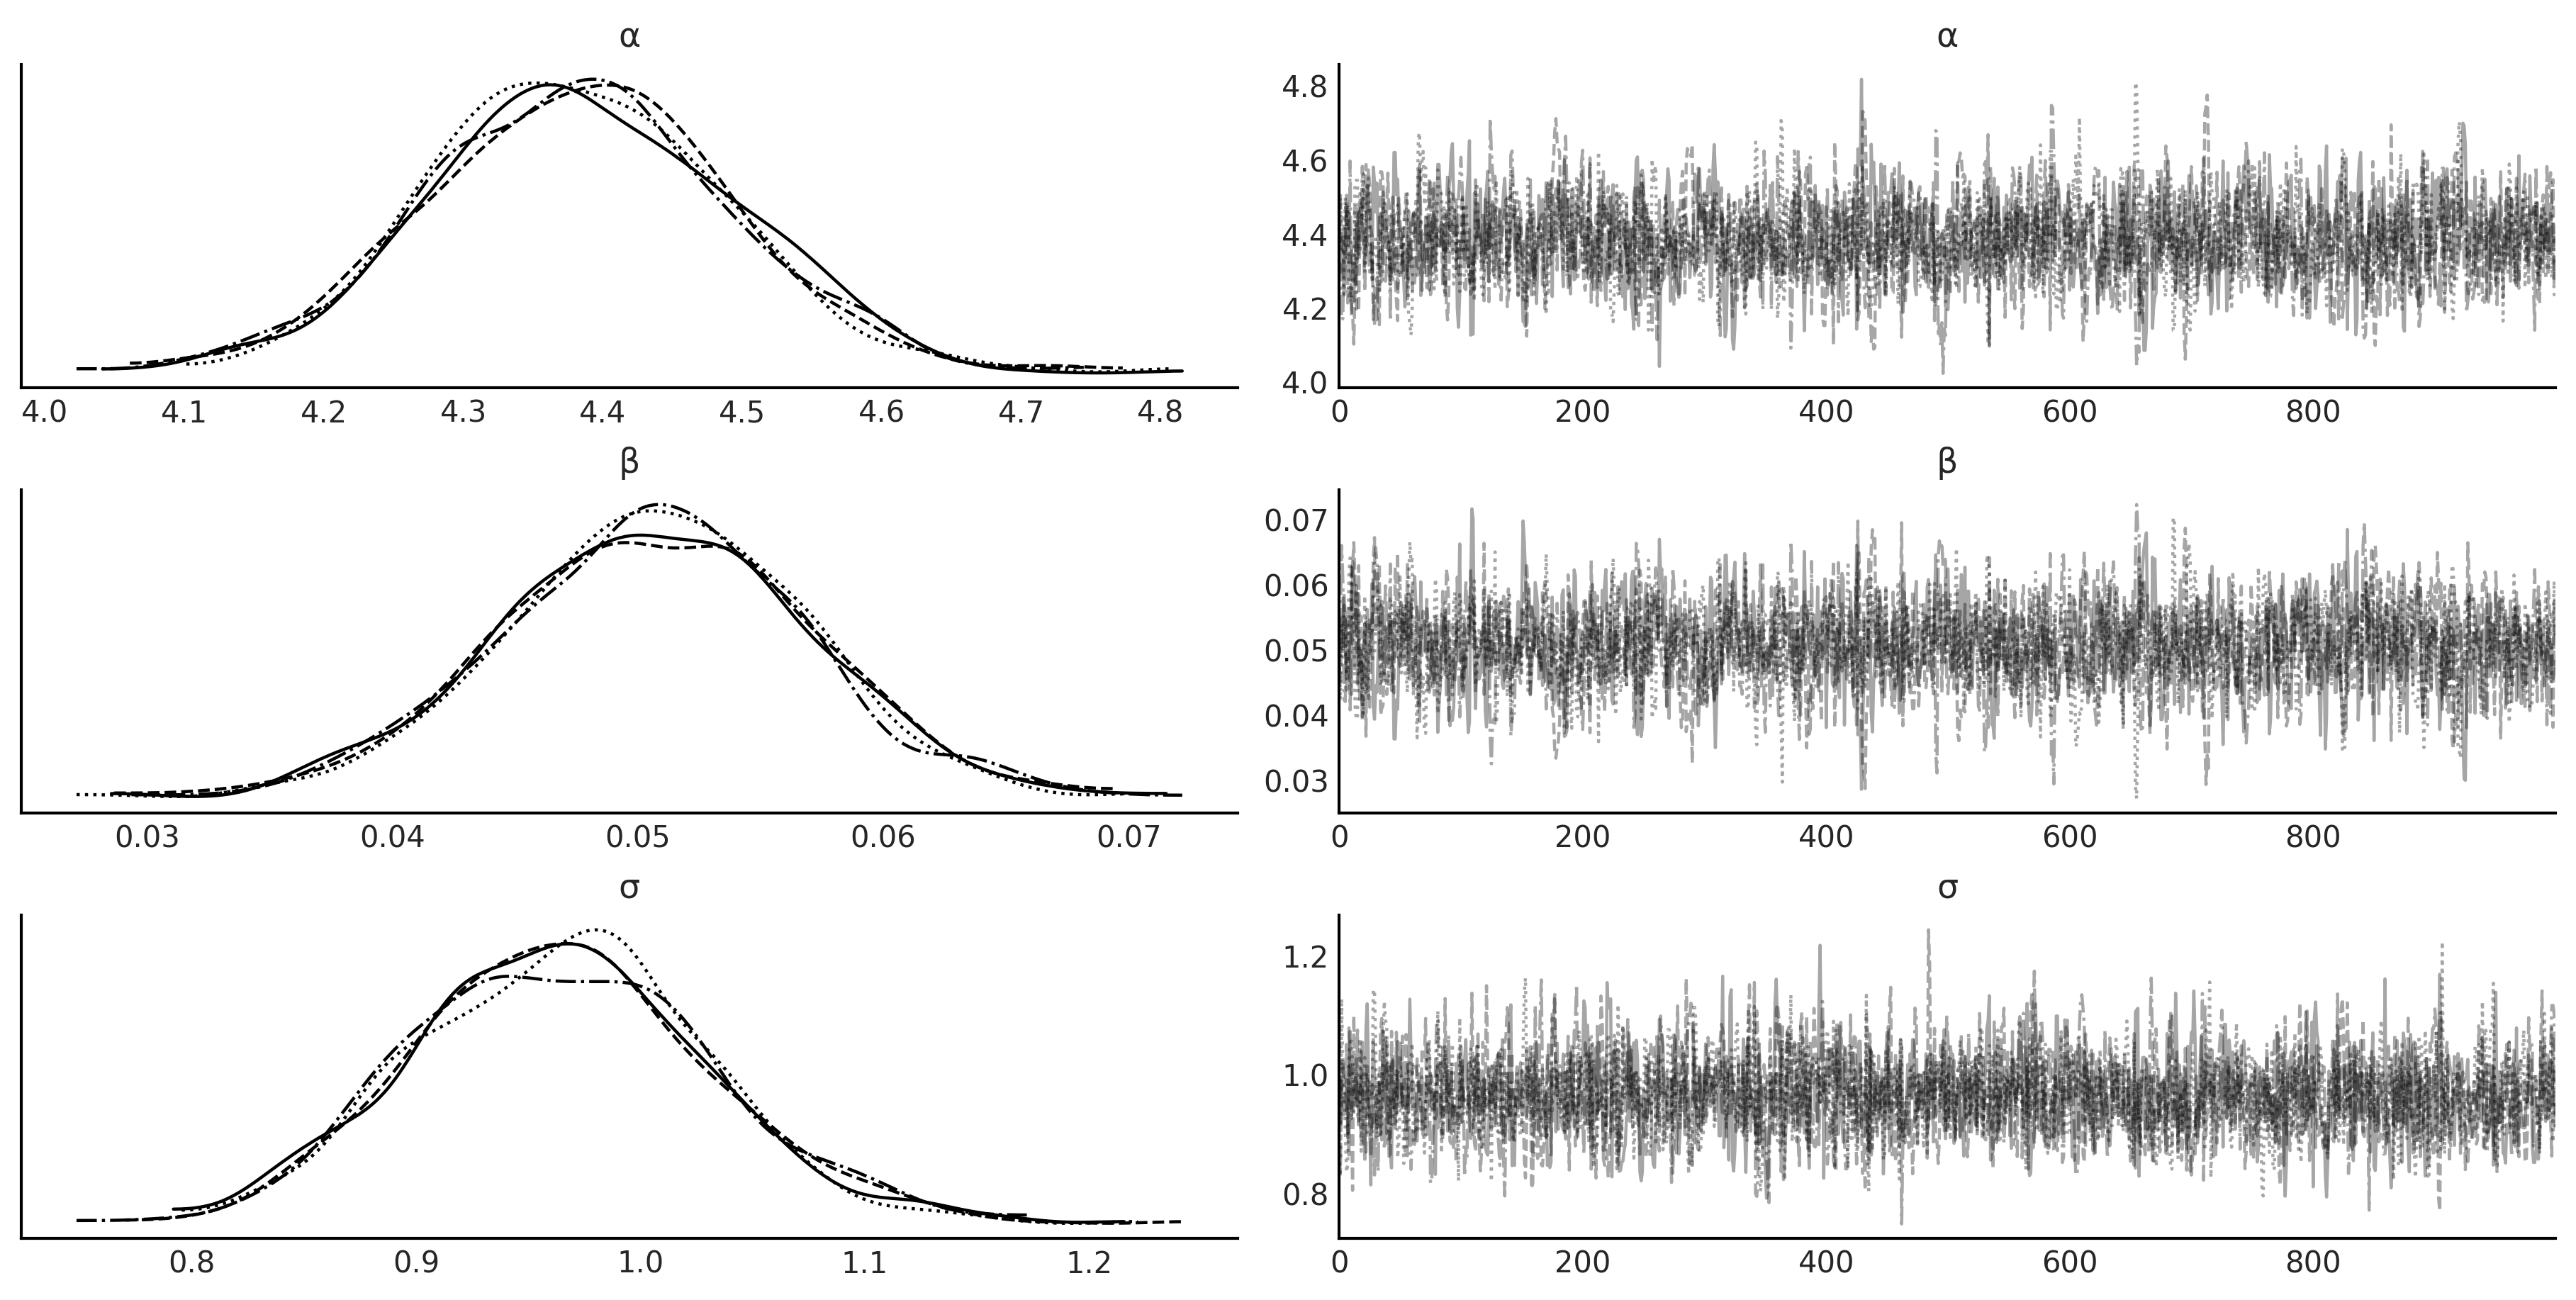

In [93]:
az.plot_trace(idata_neg, var_names=['~μ'])

In [82]:
# cmp_df = az.compare({"model_pos": idata_pos, "model_neg": idata_neg})

# az.plot_compare(cmp_df)

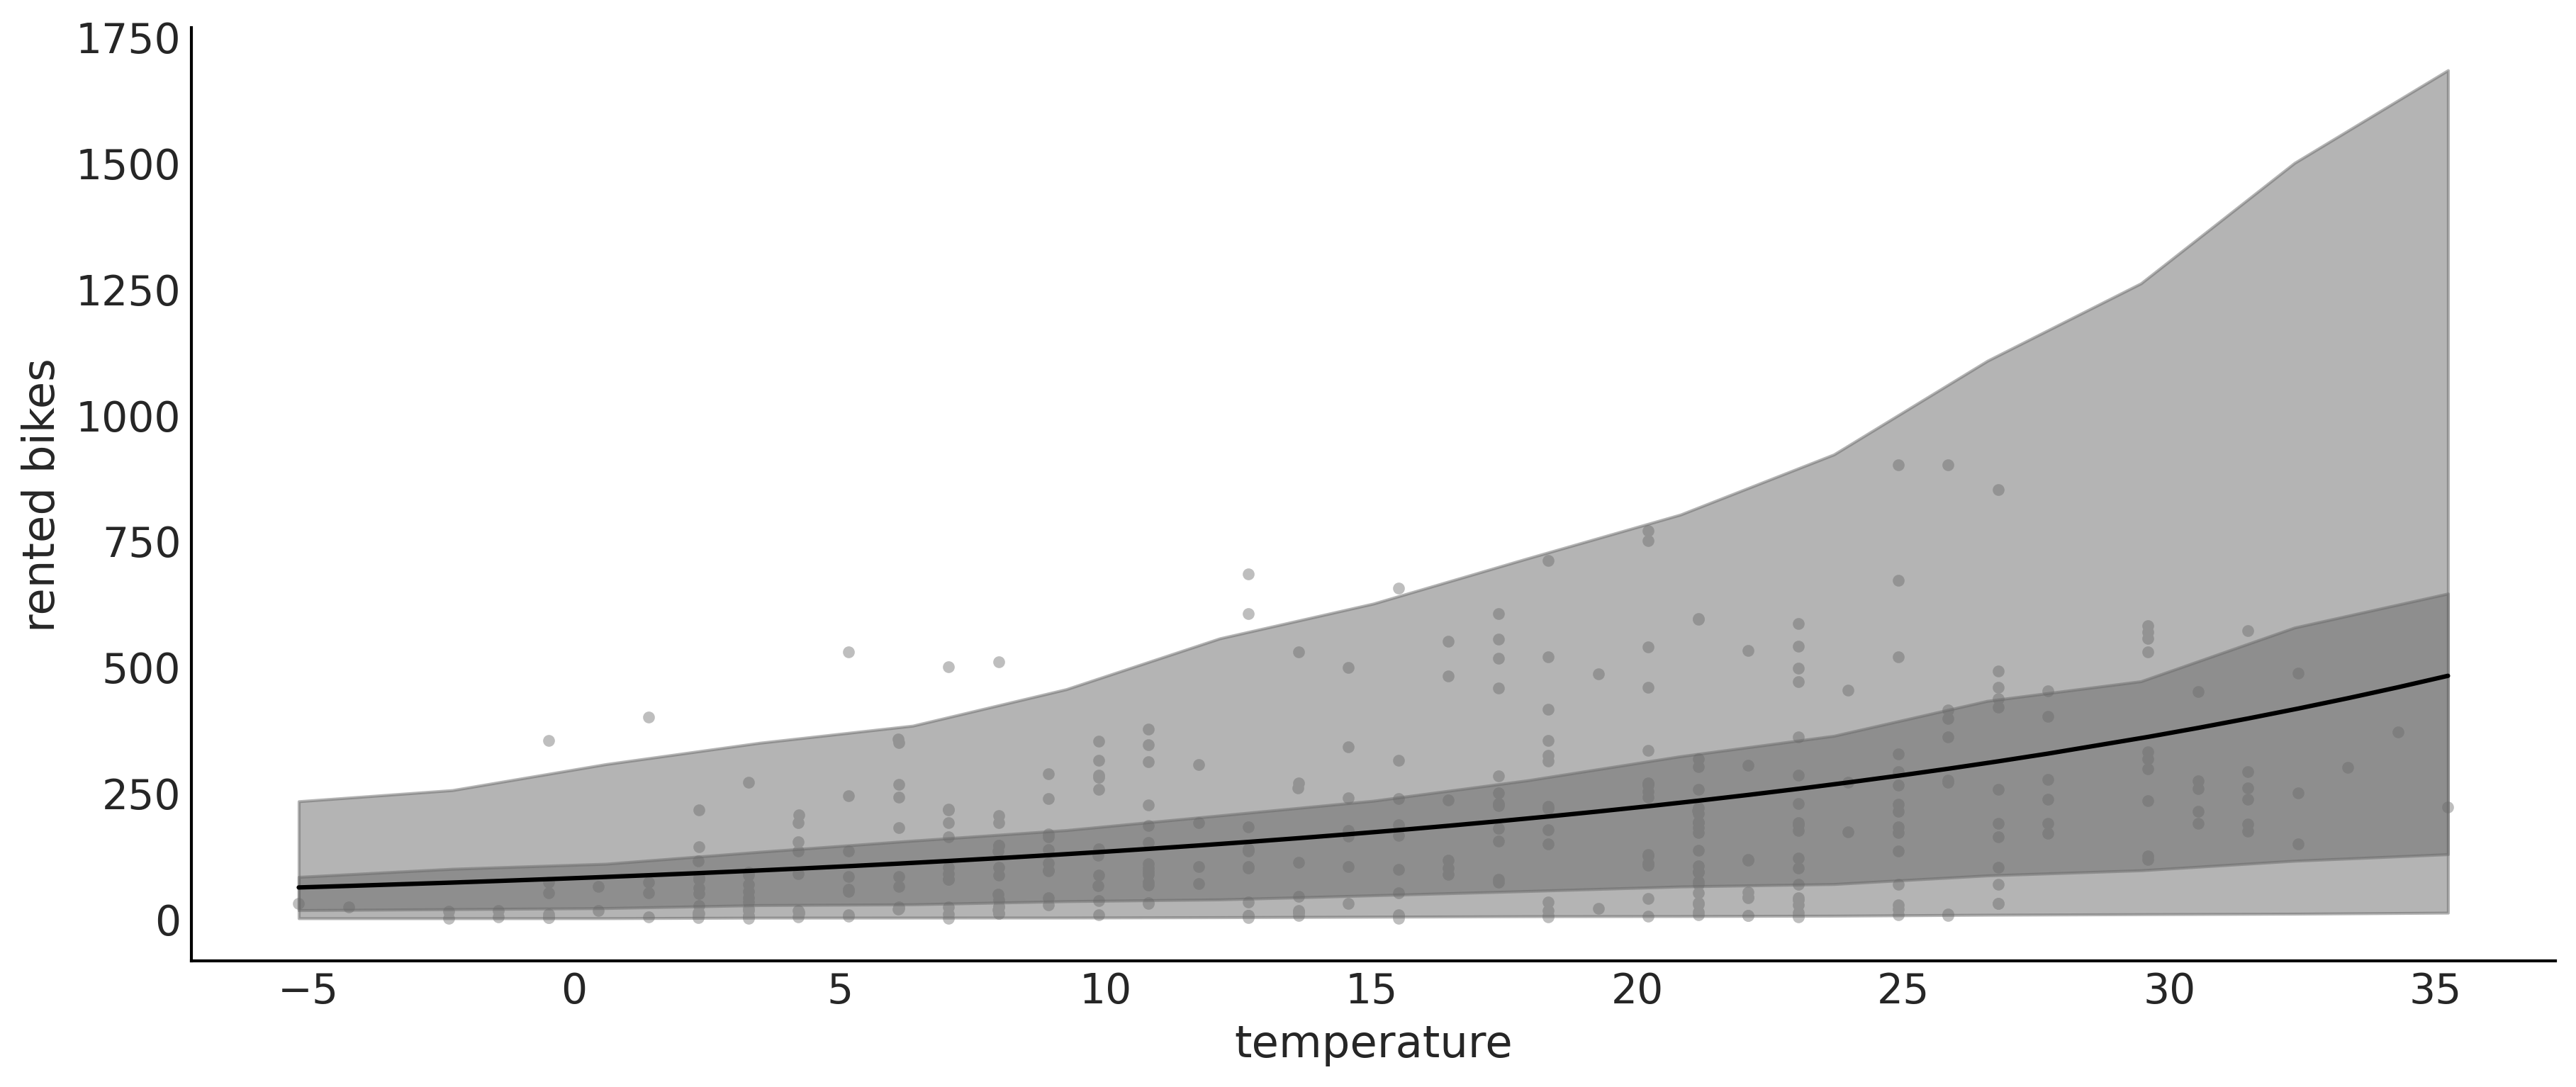

In [97]:
mean_line = idata_neg.posterior['μ'].mean(("chain", "draw"))
idx = np.argsort(bikes.temperature.values)
x = np.linspace(bikes.temperature.min(), bikes.temperature.max(), 15)
y_pred_q = idata_neg.posterior_predictive['y_pred'].quantile([0.03, 0.97, 0.25, 0.75], dim=['chain', 'draw'])
y_hat_bounds = iter([PchipInterpolator(bikes.temperature.values[idx], y_pred_q[i][idx])(x) for i in range(4)])

_, ax = plt.subplots(figsize=(12, 5))
ax.plot(bikes.temperature, bikes.rented, 'C2.', zorder=-3)
ax.plot(bikes.temperature[idx], mean_line[idx], c='C0')

for lb, ub in zip(y_hat_bounds, y_hat_bounds): 
    ax.fill_between(x,
                    lb, ub,
                    color="C1", alpha=0.5)

ax.set_xlabel('temperature')
ax.set_ylabel('rented bikes')
plt.savefig("../fig/linear_bikes_posterior_predictive_nb.png")

Text(0, 0.5, 'rented bikes')

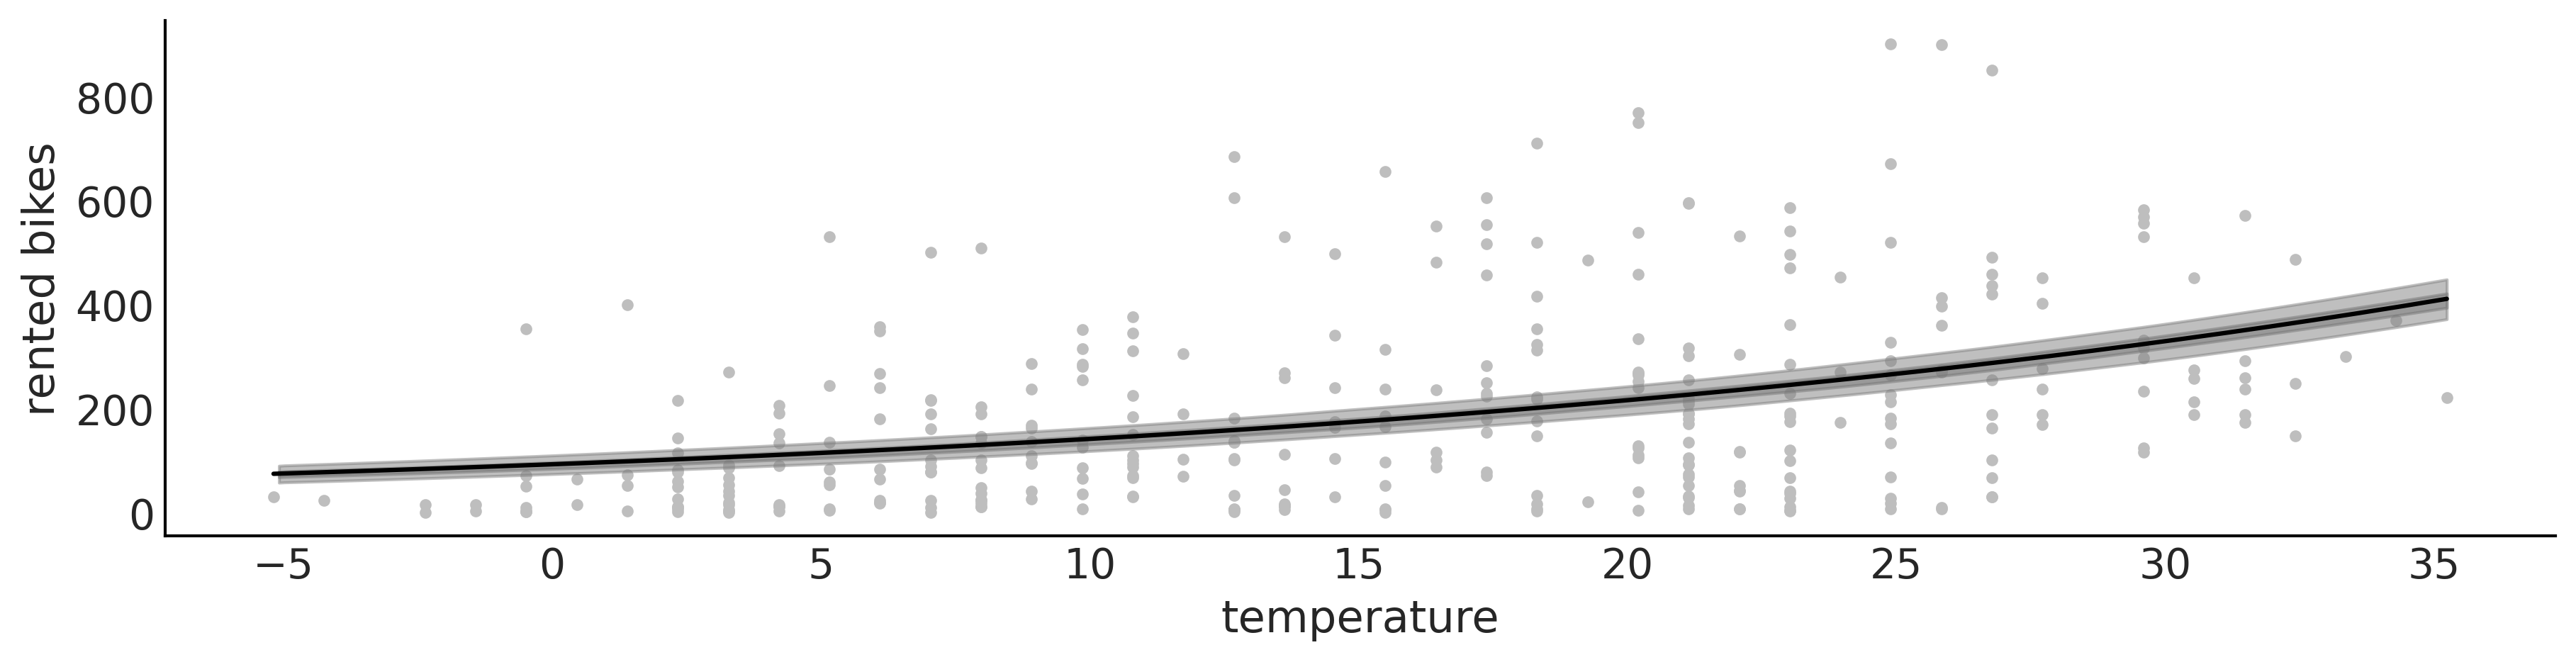

In [125]:
# posterior = az.extract(idata_pos, num_samples=50)
# x_plot = xr.DataArray(np.linspace(bikes.temperature.min(), bikes.temperature.max(), 50), dims="plot_id")
# mean_line = np.exp(posterior['α'].mean() + posterior['β'].mean() * x_plot)

# _, ax = plt.subplots(figsize=(12, 3))
# ax.plot(bikes.temperature, bikes.rented, 'C2.', zorder=-3)
# ax.plot(x_plot, mean_line, c='C0')
# az.plot_hdi(bikes.temperature, idata_pos.posterior_predictive['y_pred'], hdi_prob=0.5)
# az.plot_hdi(bikes.temperature, idata_pos.posterior_predictive['y_pred'], color='gray')
# ax.set_xlabel('temperature')
# ax.set_ylabel('rented bikes')

<AxesSubplot:xlabel='y_pred / y_pred'>

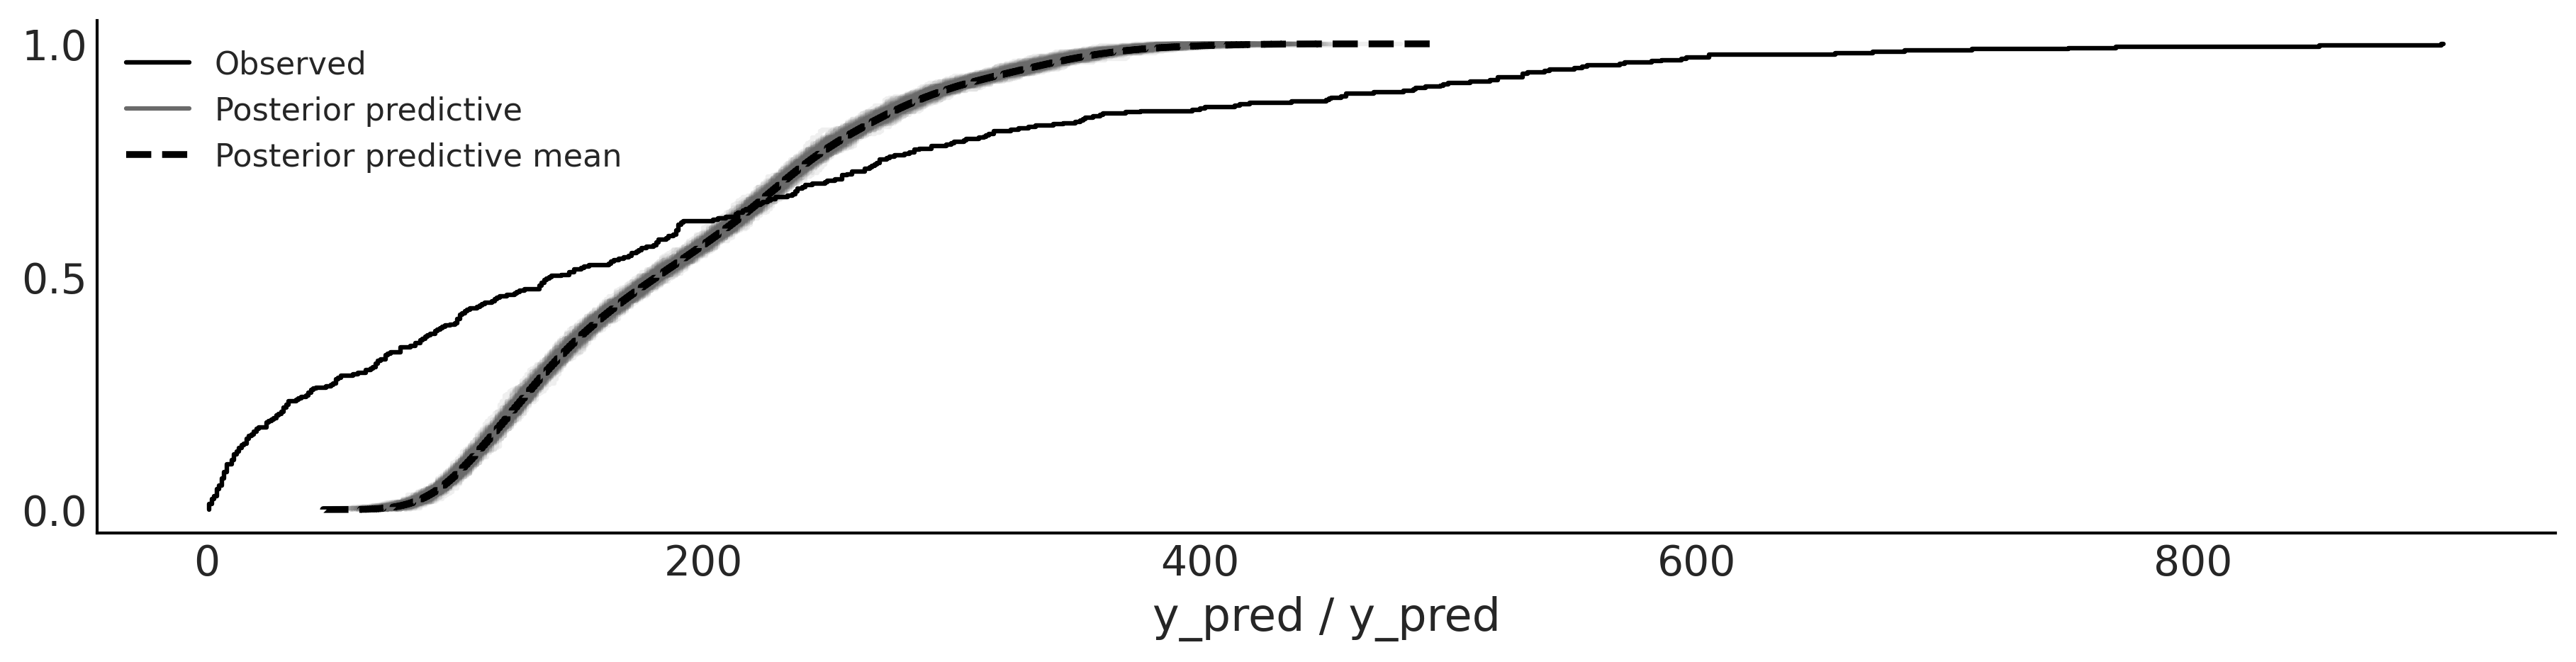

In [63]:
# az.plot_ppc(idata_pos, figsize=(12, 3), num_pp_samples=200,  alpha=0.1, kind="cumulative", colors=["C1", "C0", "C0"])

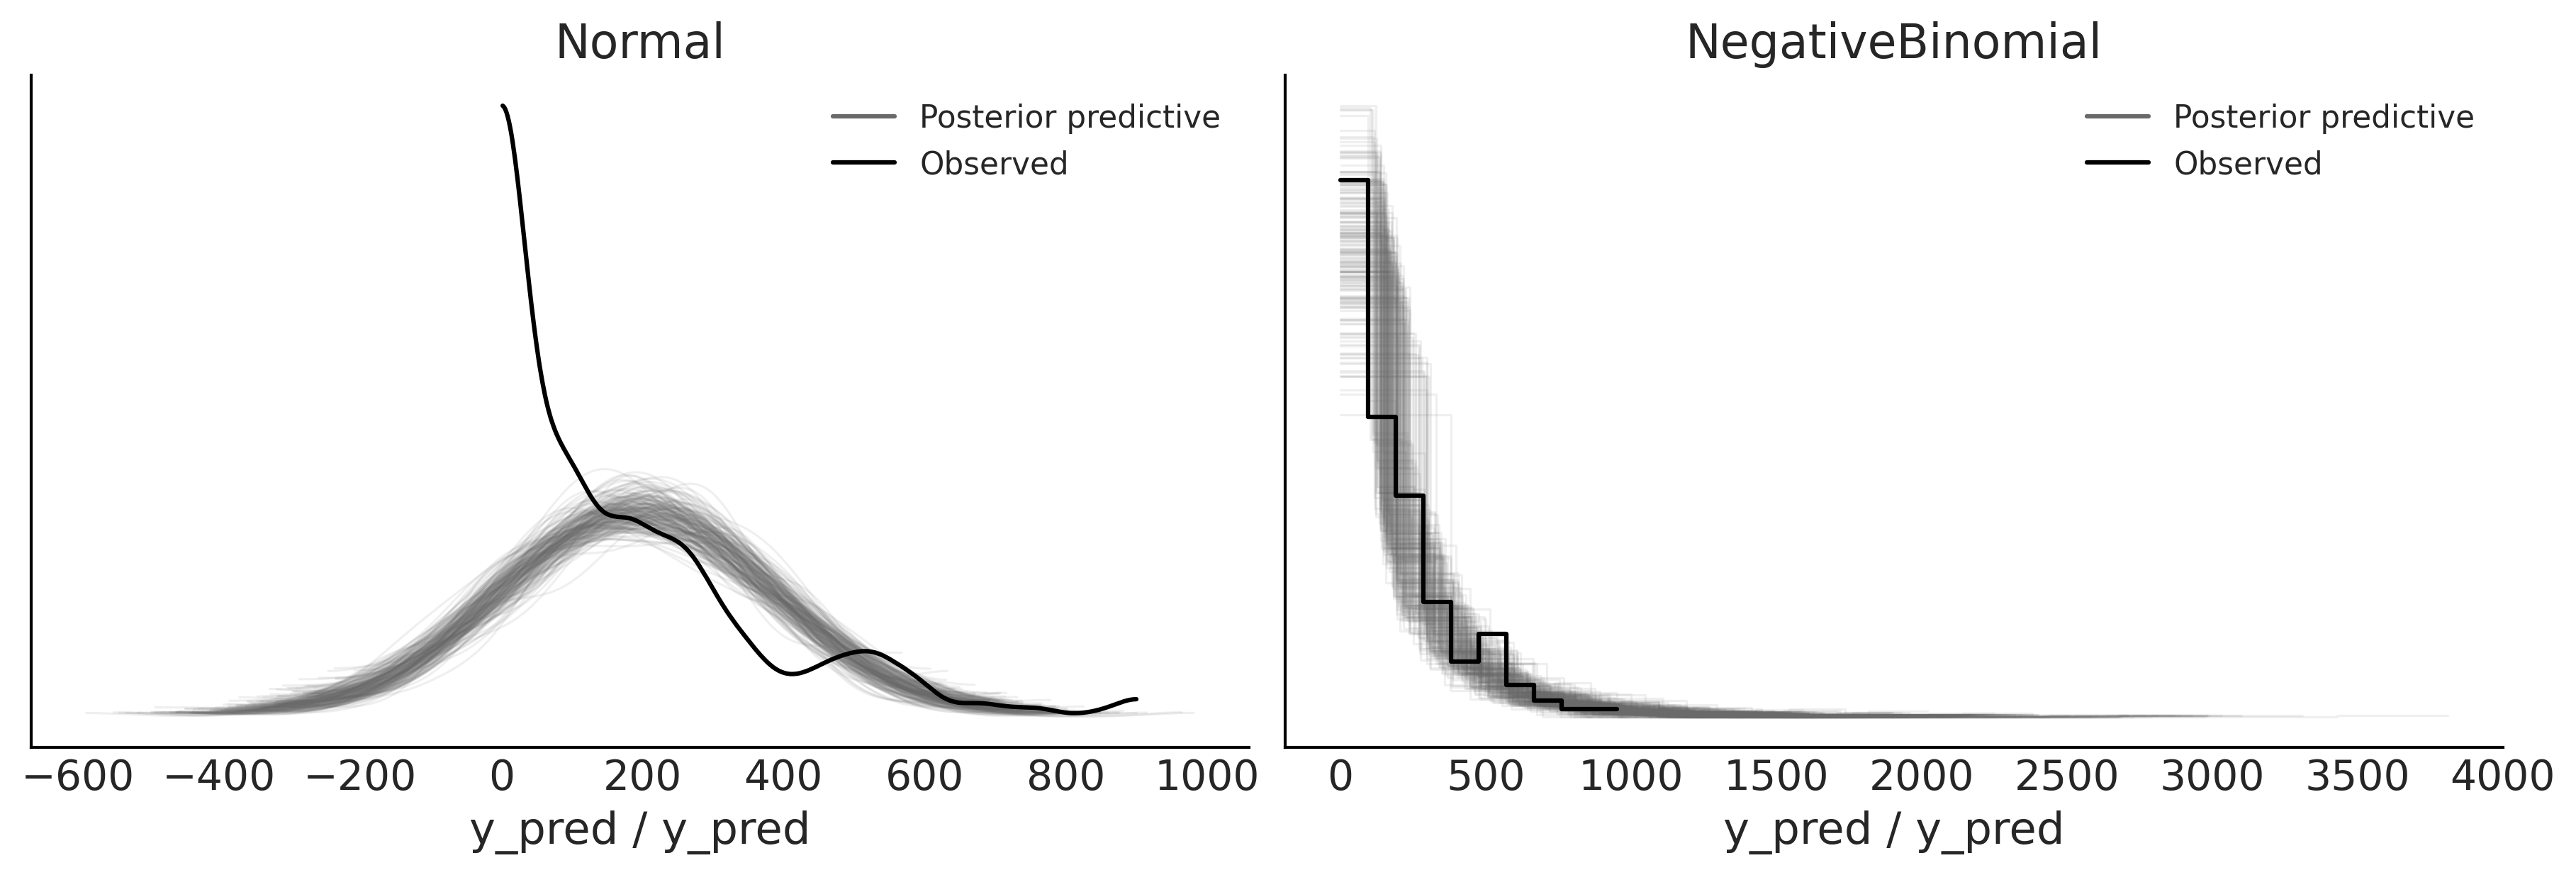

In [98]:
_, ax = plt.subplots(1, 2, figsize=(12, 4))
az.plot_ppc(idata_lb,  num_pp_samples=200,  alpha=0.1, colors=["C1", "C0", "C0"], ax=ax[0], mean=False)
az.plot_ppc(idata_neg, num_pp_samples=200,  alpha=0.1, colors=["C1", "C0", "C0"], ax=ax[1], mean=False)
ax[0].set_title("Normal")
ax[1].set_title("NegativeBinomial")


plt.savefig("../fig/linear_bikes_posterior_predictive_check.png")

Text(0, 0.5, 'y')

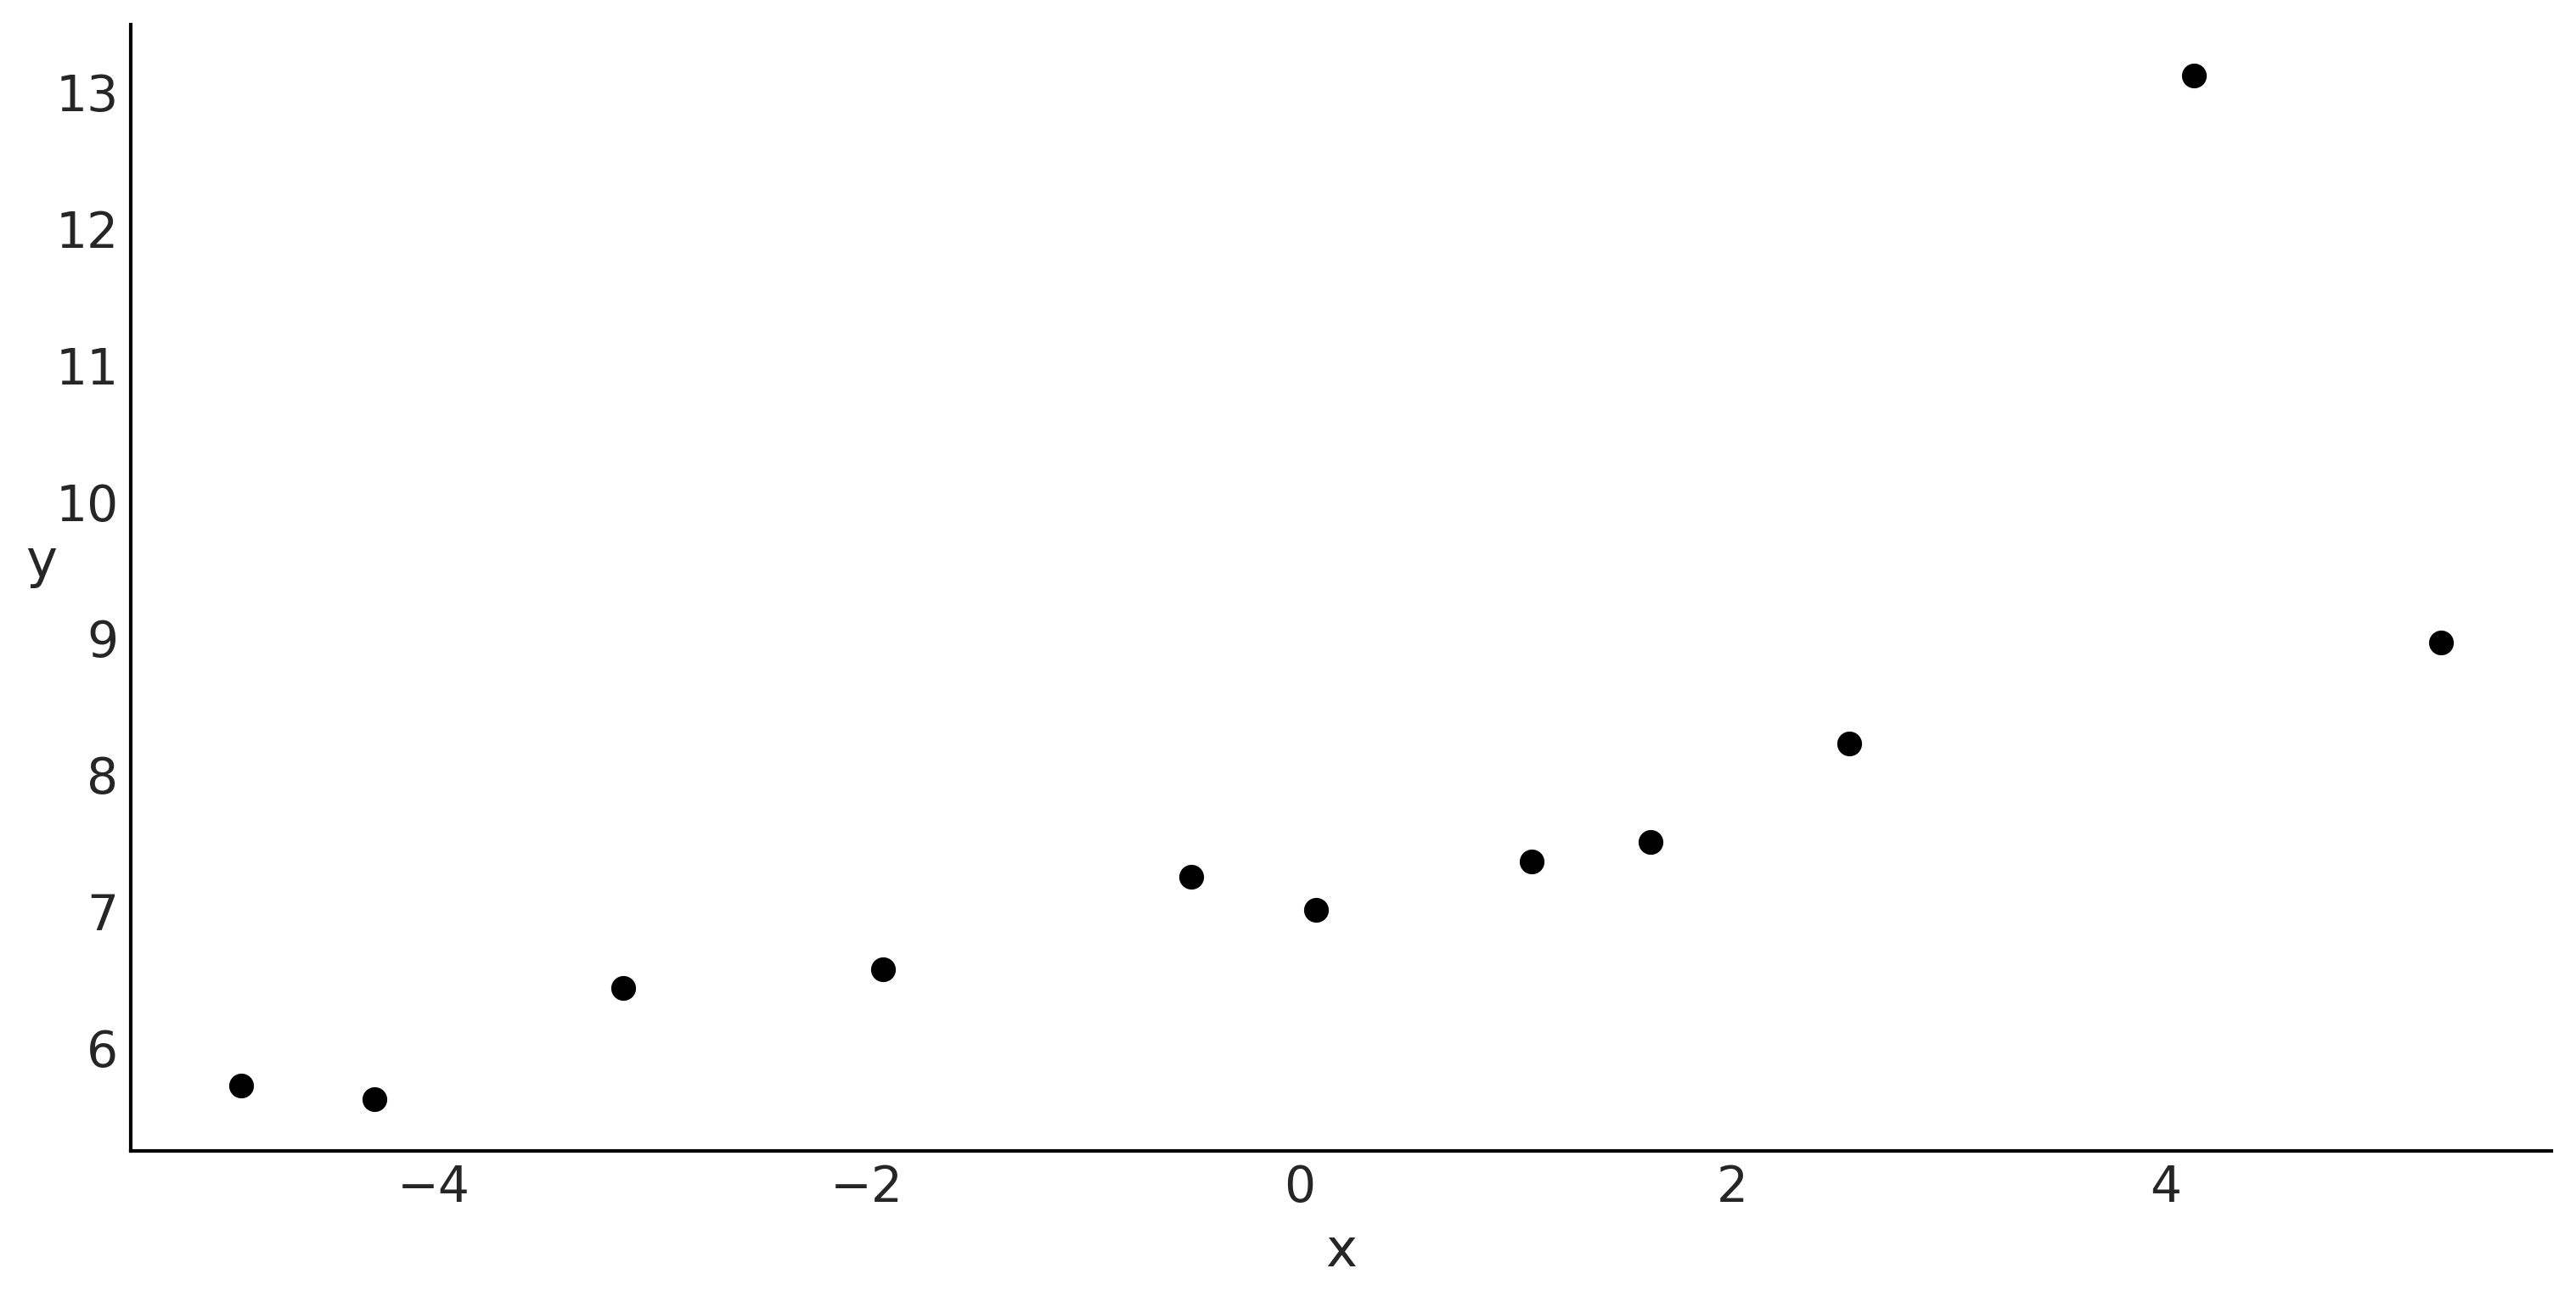

In [177]:
np.random.seed(153)
ans = pd.read_csv('data/anscombe.csv')
idx = np.argsort(ans[ans.group == 'III']['x'].values)
x_3 = np.random.normal(ans[ans.group == 'III']['x'].values[idx], 0.3)
y_3 = np.random.normal(ans[ans.group == 'III']['y'].values[idx], 0.25)
x_3 = x_3 - x_3.mean()

_, ax = plt.subplots(figsize=(10, 5))
ax.plot(x_3, y_3, 'C0o')
ax.set_xlabel('x')
ax.set_ylabel('y', rotation=0)

In [255]:
with pm.Model() as model_t:
    α = pm.Normal('α', mu=y_3.mean(), sigma=1)
    β = pm.Normal('β', mu=0, sigma=1)
    ν = pm.Exponential('ν', 30)
    σ = pm.HalfNormal('σ', 5)
    µ = pm.Deterministic("µ", α + β * x_3)
    _ = pm.StudentT('y_pred', mu=µ, sigma=σ, nu=ν+4, observed=y_3)
    idata_t = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, ν, σ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 5 seconds.


array([[<AxesSubplot:title={'center':'α'}>,
        <AxesSubplot:title={'center':'α'}>],
       [<AxesSubplot:title={'center':'β'}>,
        <AxesSubplot:title={'center':'β'}>],
       [<AxesSubplot:title={'center':'ν'}>,
        <AxesSubplot:title={'center':'ν'}>],
       [<AxesSubplot:title={'center':'σ'}>,
        <AxesSubplot:title={'center':'σ'}>]], dtype=object)

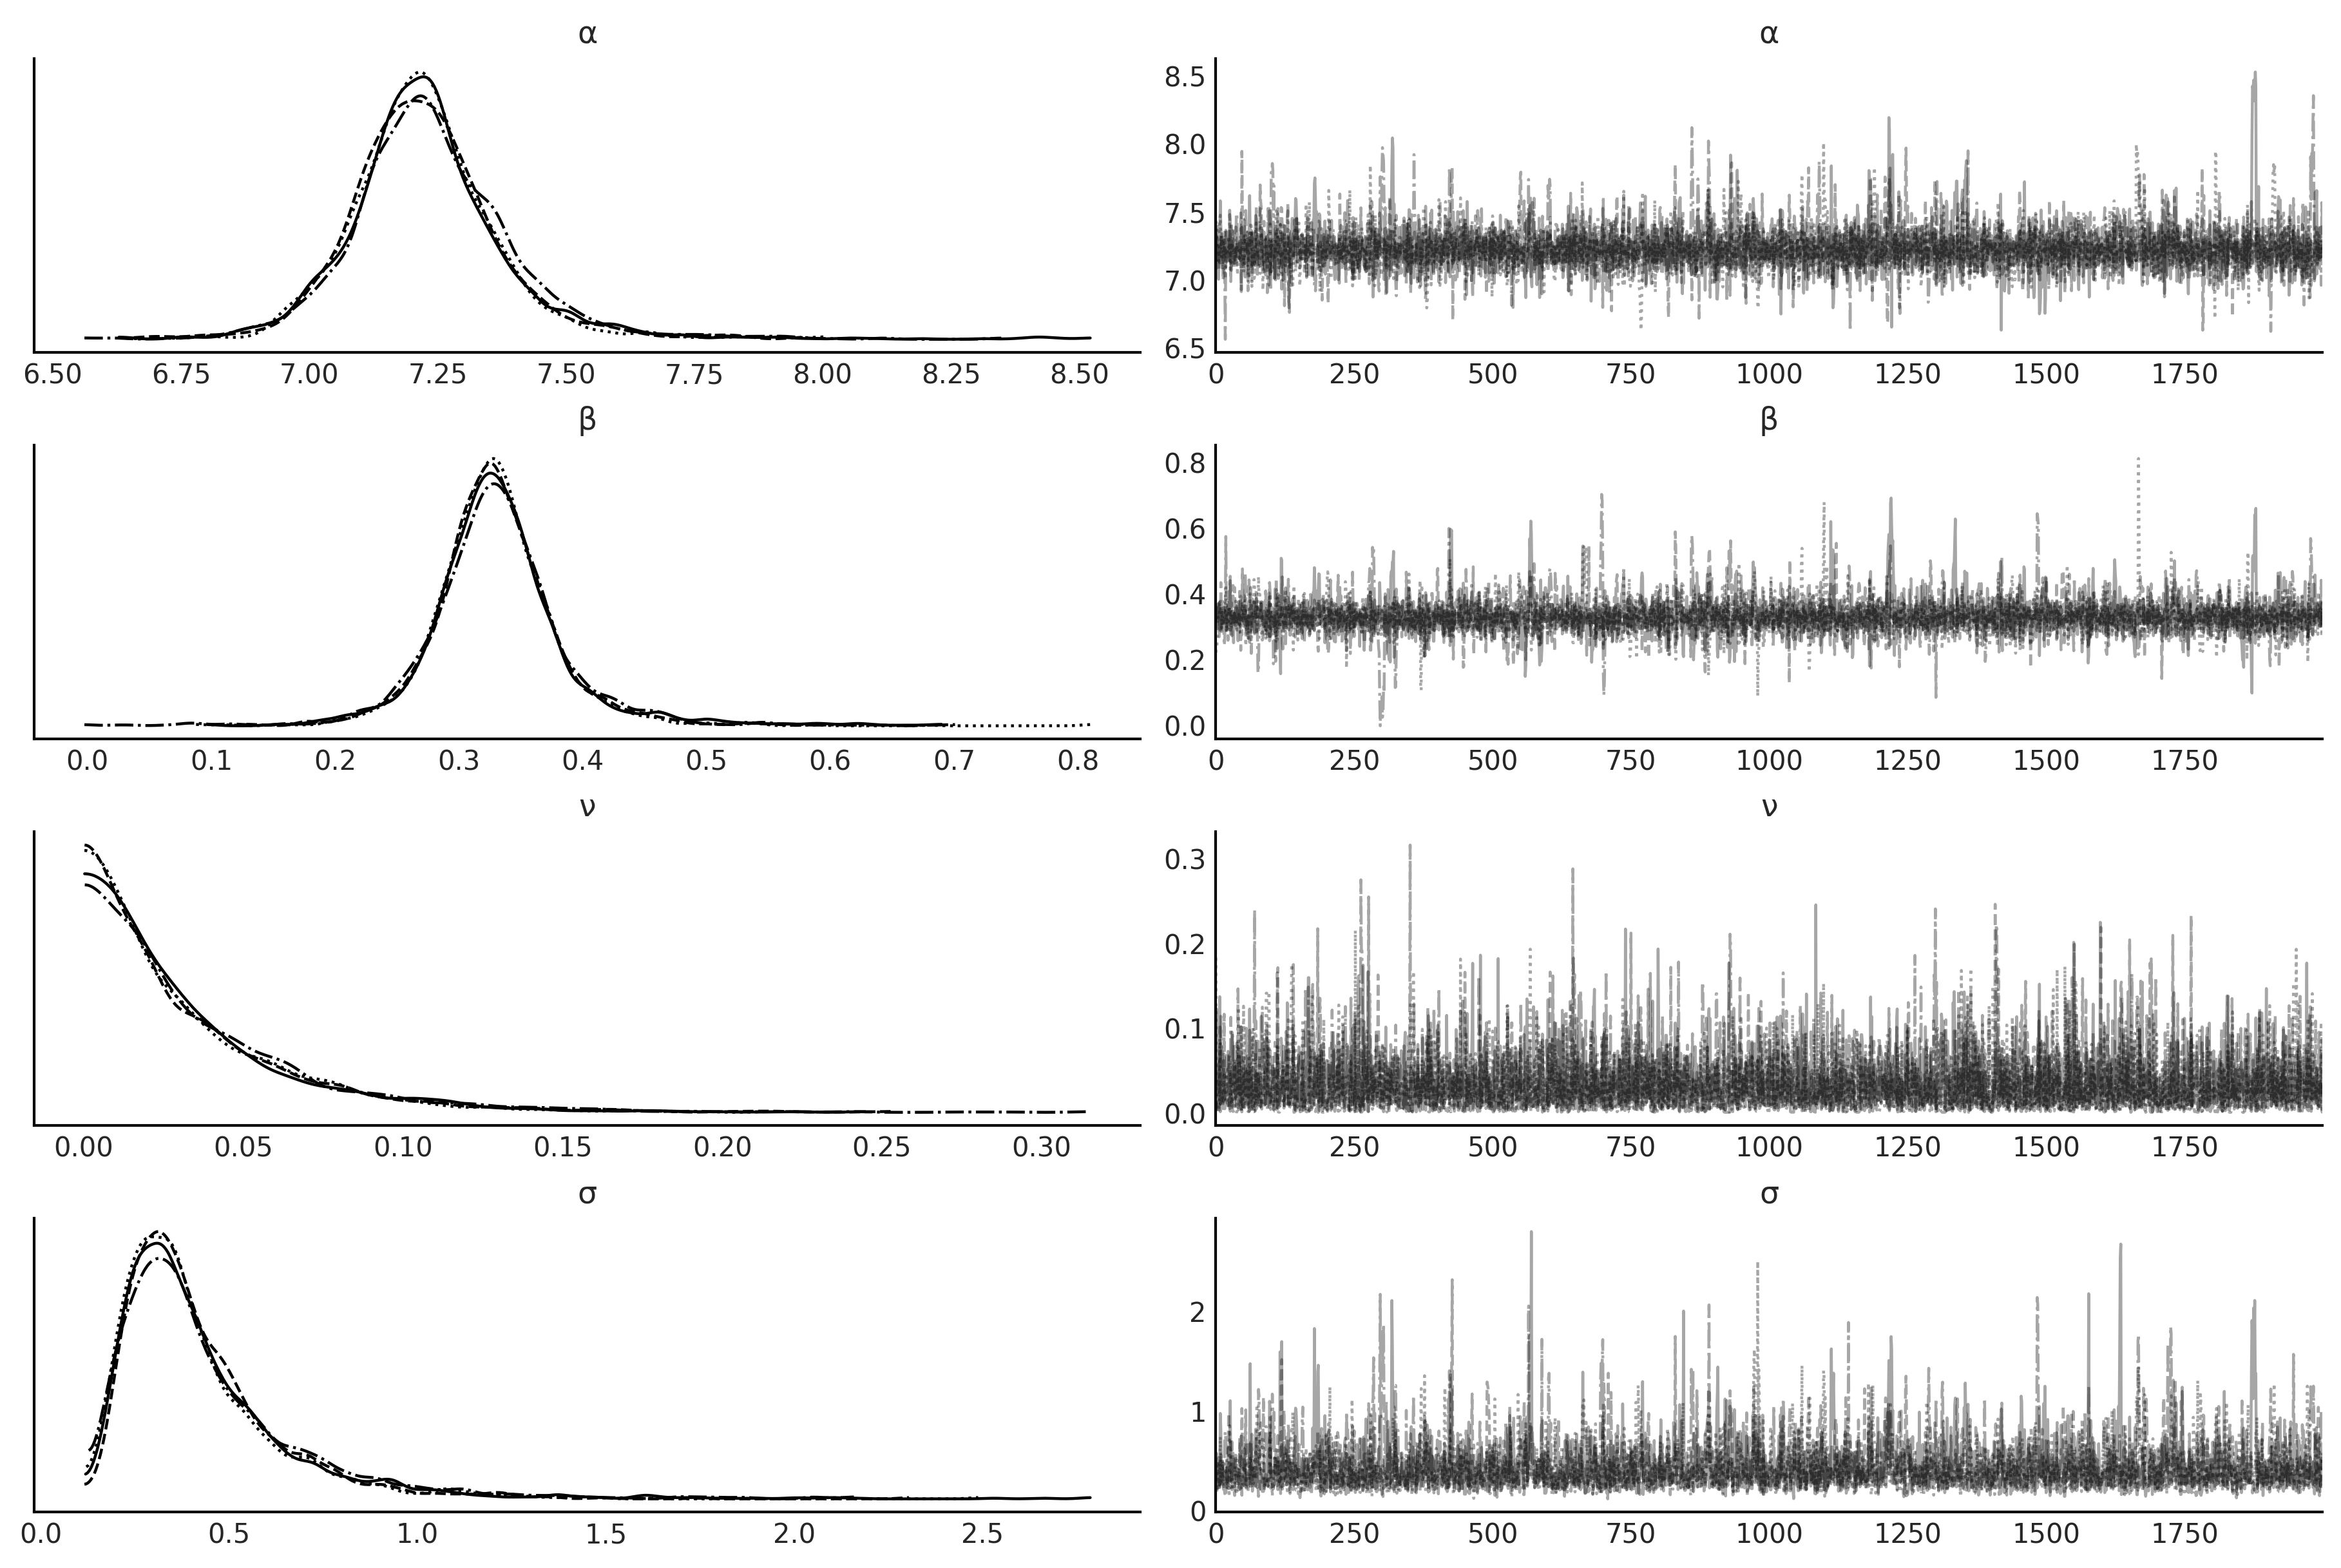

In [256]:
az.plot_trace(idata_t, var_names=["~µ"])

/home/osvaldo/proyectos/00_BM/arviz/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


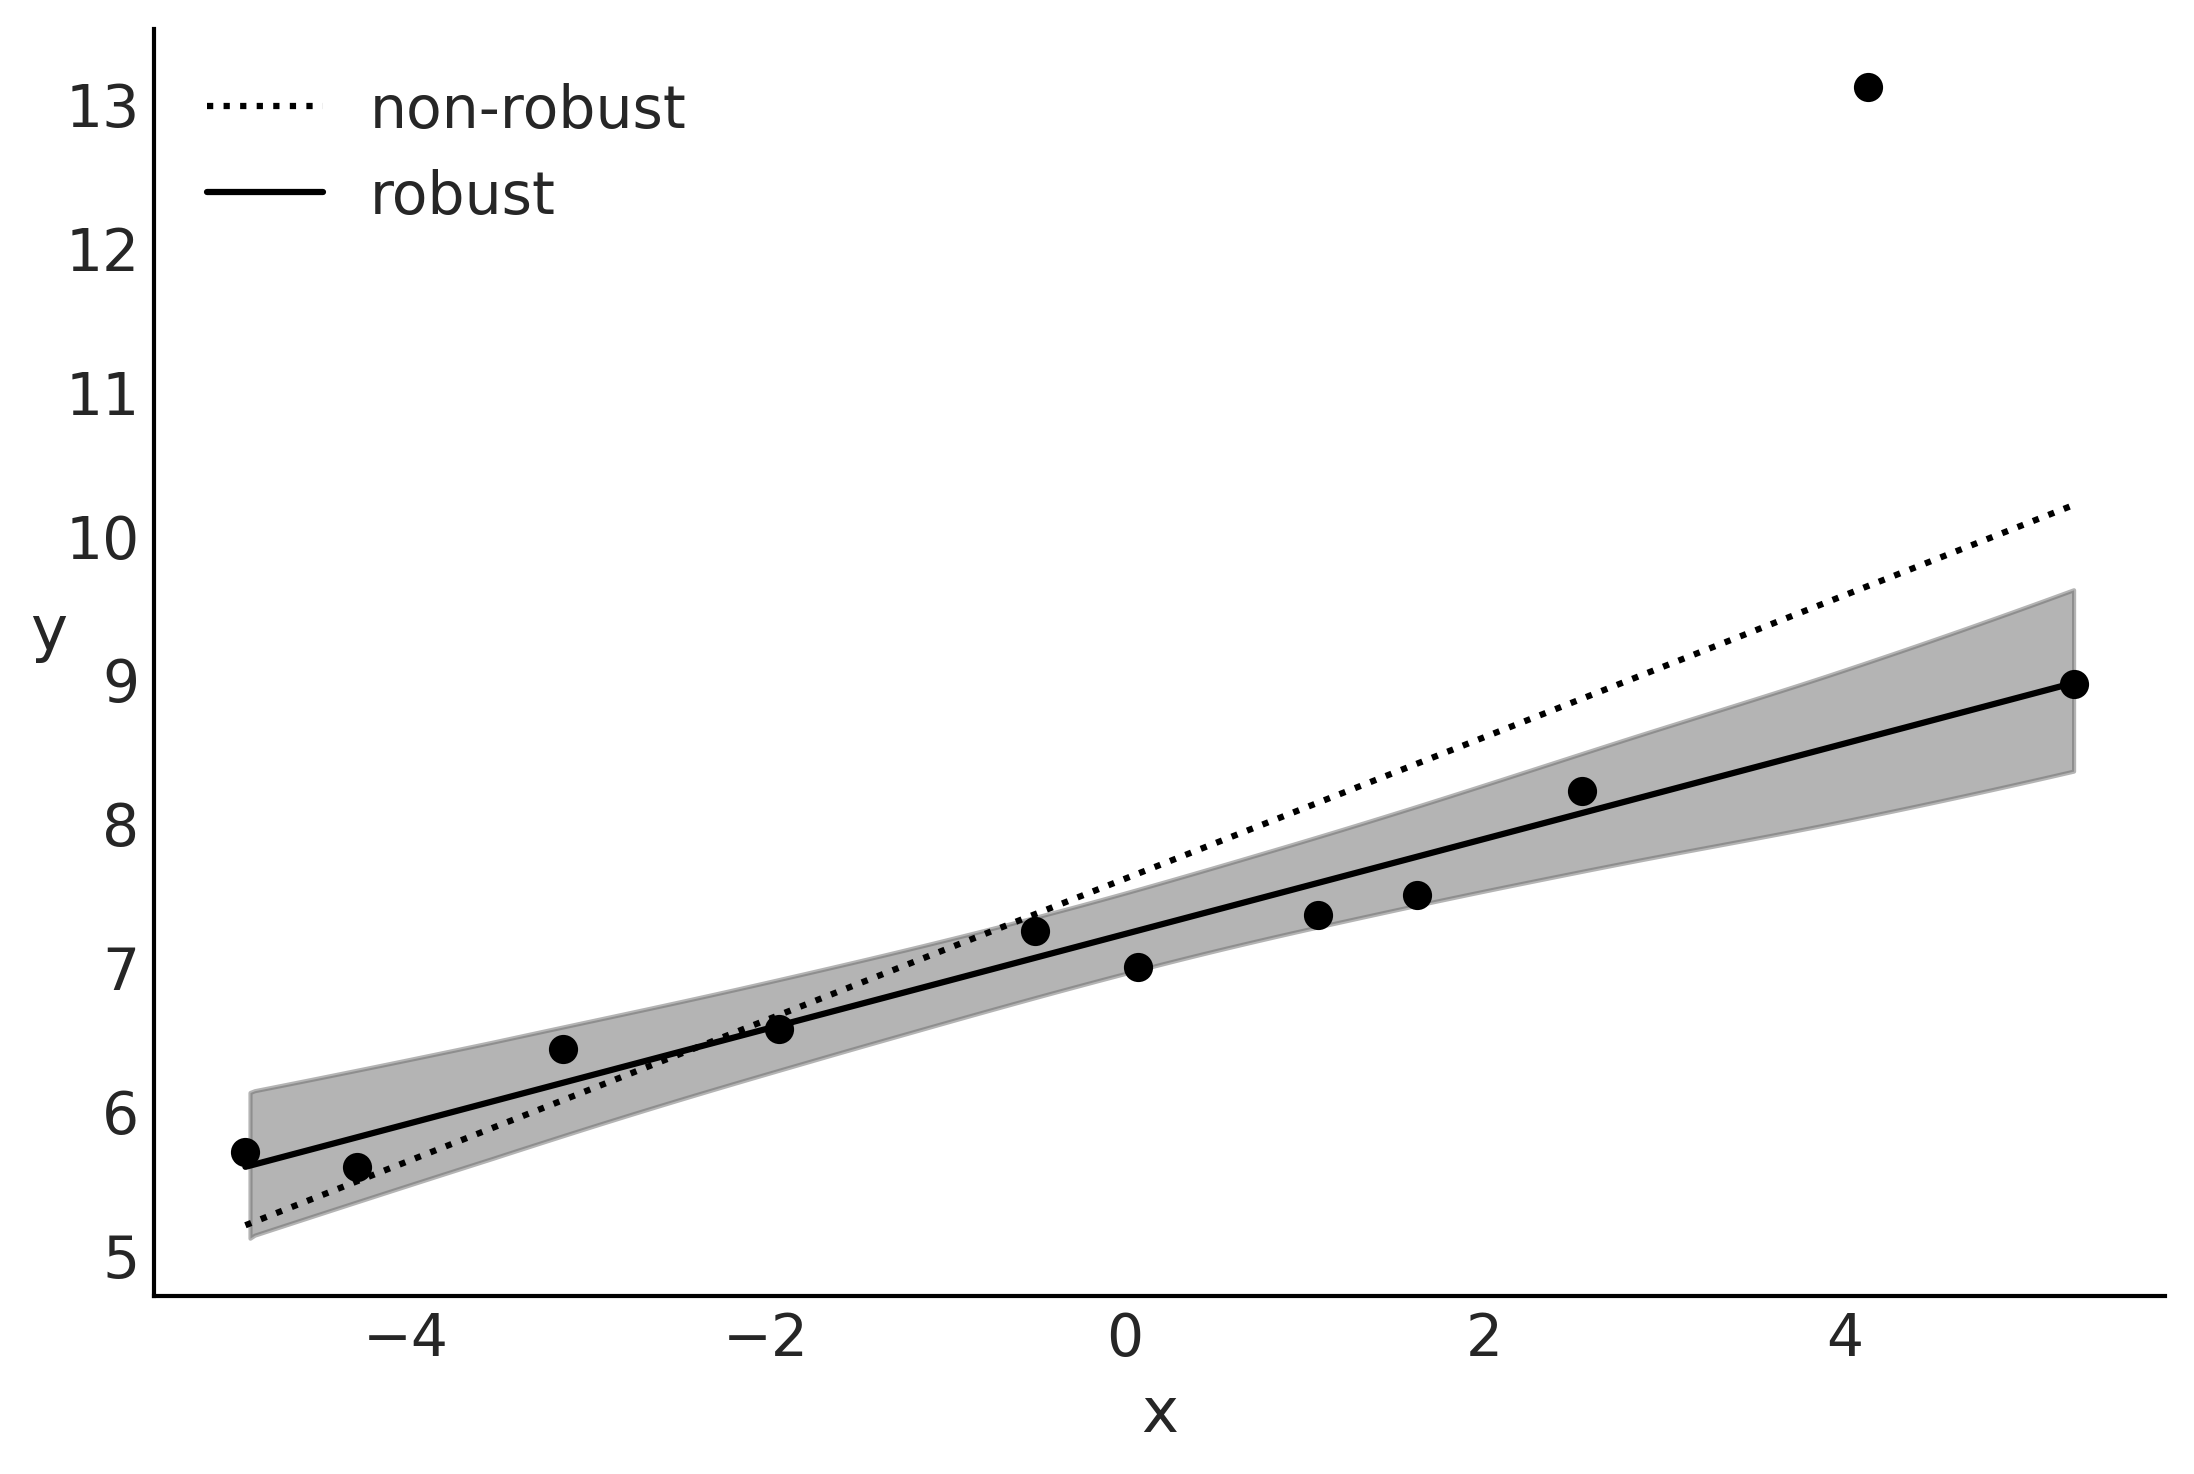

In [257]:
beta_c, alpha_c, *_ = linregress(x_3, y_3)

_, ax = plt.subplots()
ax.plot(x_3, (alpha_c + beta_c * x_3), 'C0:', label='non-robust')
ax.plot(x_3, y_3, 'C0o')
alpha_m = idata_t.posterior['α'].mean(("chain", "draw"))
beta_m = idata_t.posterior['β'].mean(("chain", "draw"))

x_plot = xr.DataArray(np.linspace(x_3.min(), x_3.max(), 50), dims="plot_id")
ax.plot(x_plot, alpha_m + beta_m * x_plot, c='C0', label="robust")
az.plot_hdi(x_3, az.hdi(idata_t.posterior['µ'])['µ'].T, ax=ax)
ax.set_xlabel('x')
ax.set_ylabel('y', rotation=0)
ax.legend(loc=2)
plt.savefig("../fig/linear_robust_regression.png")

In [258]:
az.summary(idata_t, var_names=["~µ"], round_to=2, kind="stats")

mean    sd  hdi_3%  hdi_97%
α  7.23  0.15    6.95     7.51
β  0.33  0.05    0.24     0.43
ν  0.03  0.03    0.00     0.09
σ  0.43  0.23    0.15     0.83

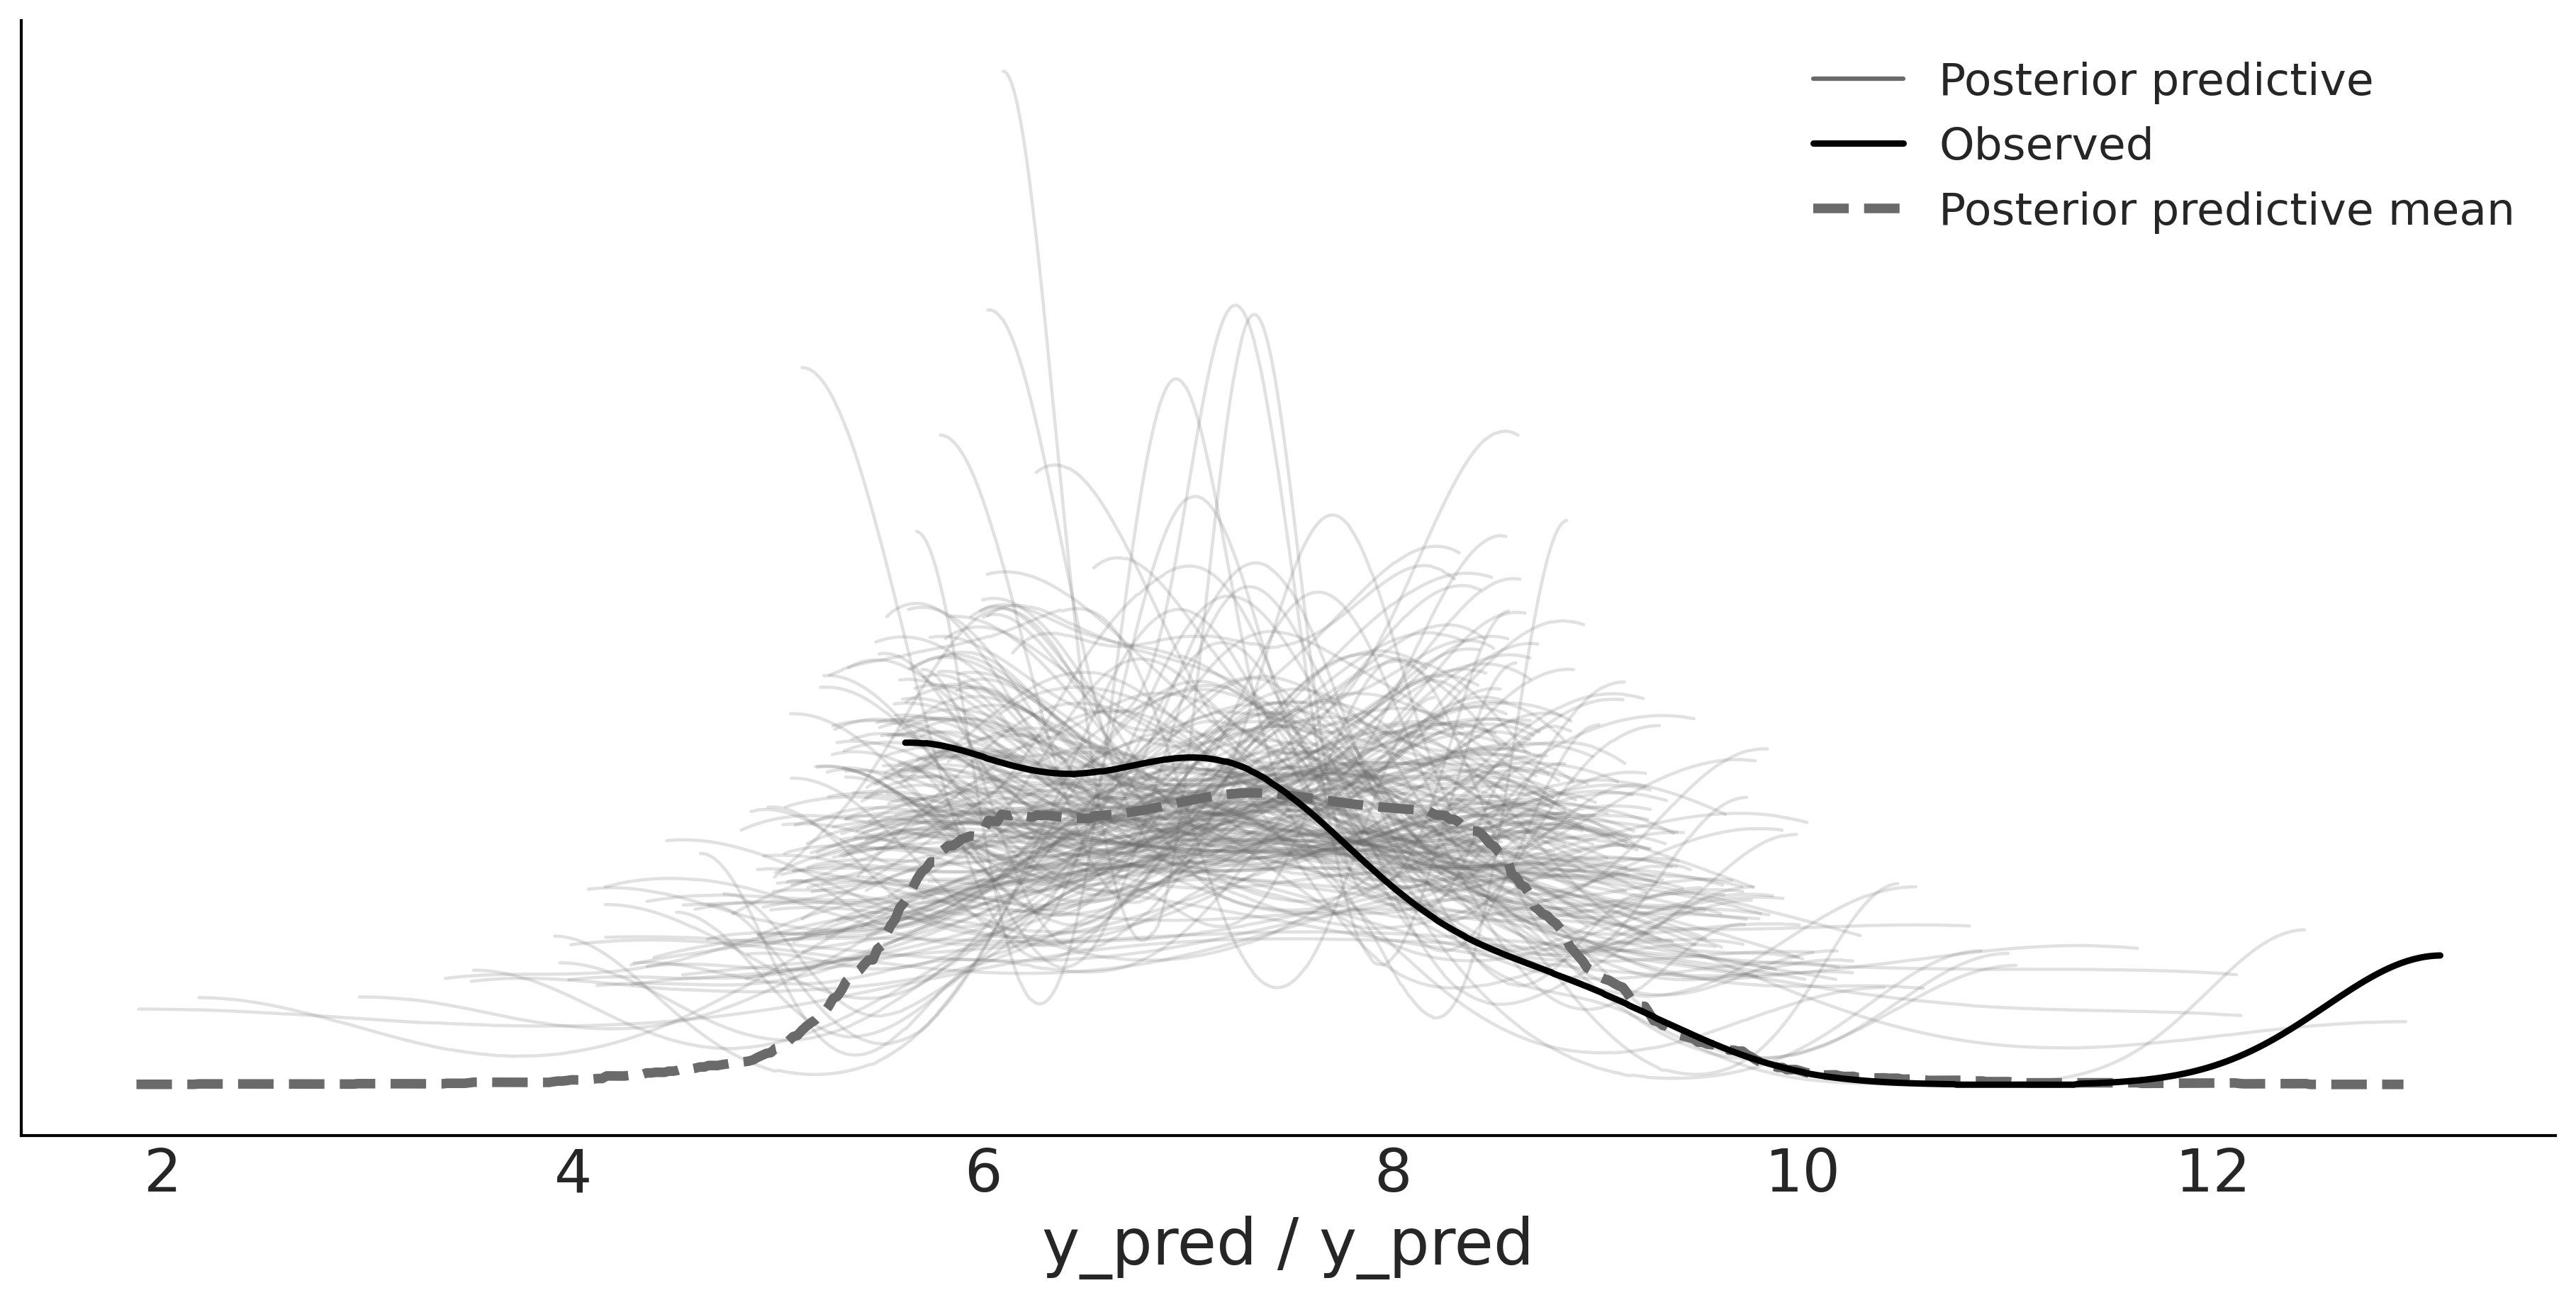

In [260]:
pm.sample_posterior_predictive(idata_t, model=model_t, random_seed=2, extend_inferencedata=True)
ax = az.plot_ppc(idata_t, num_pp_samples=200, figsize=(12, 6),  colors=["C1", "C0", "C1"])
plt.savefig("../fig/linear_robust_regression_ppc.png")